In [1]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, color_map='viridis')
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
col_pal = [
    '#ff0000',
    '#94BFB1',
    '#B49EC8',
    '#E0EE70',
    '#EE943E',
    '#4C7BAB',
    '#E78AB8',
    '#AFBFCC',
    '#814F75',
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"
]

In [3]:
run_name = 'YS_fliv_ery_HB'
save_loc = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad'
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV"

# Required: Name of first object
data2 = "_ys"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Required: Name of second object
data1 = "_fliv"
# Provide categorical to join between datasets
cat1 = "cell.labels"

# V2 trend plotter

In [85]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig2_Haem/Erytrhroid_HB_percentage/YS_fliv_ery_HB.h5ad')


In [86]:
np.min(adata.X)

0.0

In [87]:
keep = [
 'Erythroid_ys',
 'Erythroid_fliv',
# 'Embryonic_Erythroid_fliv',
 'Erythroid_Yolk Sac_gastrulation',]

adata = adata[adata.obs['corr_concat'].isin(keep)]

In [88]:
adata.obs['tissue']

Wang_et_al_AAACCTGGTAACGACG_1-0          YS
Wang_et_al_AAACCTGGTCAAAGAT_1-0          YS
Wang_et_al_AAACCTGGTCCGAAGA_1-0          YS
Wang_et_al_AAACCTGGTCCGCTGA_1-0          YS
Wang_et_al_AAACCTGGTCTGGAGA_1-0          YS
                                     ...   
SS.sc7785574-1                     gastrula
SS.sc7785551-1                     gastrula
SS.sc7785334-1                     gastrula
SS.sc7785483-1                     gastrula
SS.sc7785288-1                     gastrula
Name: tissue, Length: 60947, dtype: category
Categories (3, object): ['Liver', 'YS', 'gastrula']

In [89]:
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)
# sc.pp.regress_out(adata, ["tissue"], n_jobs=None, copy=False)
#sc.pp.scale(adata, max_value=5,zero_center=True)

In [90]:
# adata_concat = adata[adata.obs['stage']==0]
# for i in adata.obs['stage'].unique():
#     tmp = adata[adata.obs['stage'].isin([i])]
#     sc.pp.scale(tmp, max_value=10,zero_center=True)
#     adata_concat = adata_concat.concatenate(tmp, join='inner')
# adata = adata_concat[:]

In [91]:
keys = {
'gower1':['HBZ','HBE1'],
'gower2':['HBA1','HBA2','HBE1'],
# 'HBB':['HBB'],
#  'HBD':['HBD'],
#  'HBE1':['HBE1'],
#  'HBG1':['HBG1'],
#  'HBG2':['HBG2'],
#  'HBM':['HBM'],
#  'HBP1':['HBP1'],
#  'HBQ1':[ 'HBQ1'],
#  'HBZ':['HBZ'] 
}
keys2 = {
 'HBZ':['HBZ'],
 'HBE1':['HBE1'],
 'HBA1':['HBA1'],
 'HBA2':['HBA2'],
 'HBQ1':[ 'HBQ1'], 
 'HBG1':['HBG1'],
 'HBG2':['HBG2'],
 'HBM':['HBM'],
 'HBB':['HBB'],
 'HBD':['HBD'],
'repressors':['BCL11A','ZBTB7A'],}

regulators = ['BCL11A','ZBTB7A']

In [92]:
# sc.pp.scale(adata, max_value=5,zero_center=True)

# Gower 1/2

In [21]:
#plt.rcdefaults()
# pl = sc.pl.dotplot(adata, var_names = keys2, groupby='stage_groups',dendrogram=False, color_map='Reds', show = True,standard_scale='var',swap_axes=True,return_fig = True)
# #pl = sc.pl.matrixplot(adata, keys2, 'stage_groups',cmap = 'rocket_r',standard_scale='var',swap_axes=True,return_fig = True, vcenter=0.5, vmax=1.2)
# pl.add_totals().show()
sc.pl.dotplot(adata, var_names = keys2, groupby='stage_groups',dendrogram=False, color_map='Reds', show = True,standard_scale='var',swap_axes=True,return_fig = False,save = 'ery_HB_repressor_dotplot')

ValueError: groupby has to be a valid observation. Given stage_groups, is not in observations: ['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'corr_concat', 'lr_batch', 'Unnamed: 0', 'X0', 'X1', 'cluster_id', 'sub_cluster', 'cluster', 'origin', 'size_factor', 'celltype_origin', 'batch', 'n_counts', 'V6_old_indexes', 'col', 'num', 'corr_concat_num', 'predicted', 'subclusters']

In [22]:
# #pl = sc.pl.violin(adata, var_names = keys2, groupby='stage_groups',dendrogram=False, color_map='Reds', show = True,standard_scale='var',swap_axes=True,return_fig = True)
# sc.pl.stacked_violin(adata, var_names = keys2, groupby='stage_groups',dendrogram=False, color_map='Reds', show = True,standard_scale='var',swap_axes=True,return_fig = False)
# #pl = sc.pl.matrixplot(adata, keys2, 'stage_groups',cmap = 'rocket_r',standard_scale='var',swap_axes=True,return_fig = True, vcenter=0.5, vmax=1.2)
# #pl.add_totals().show()

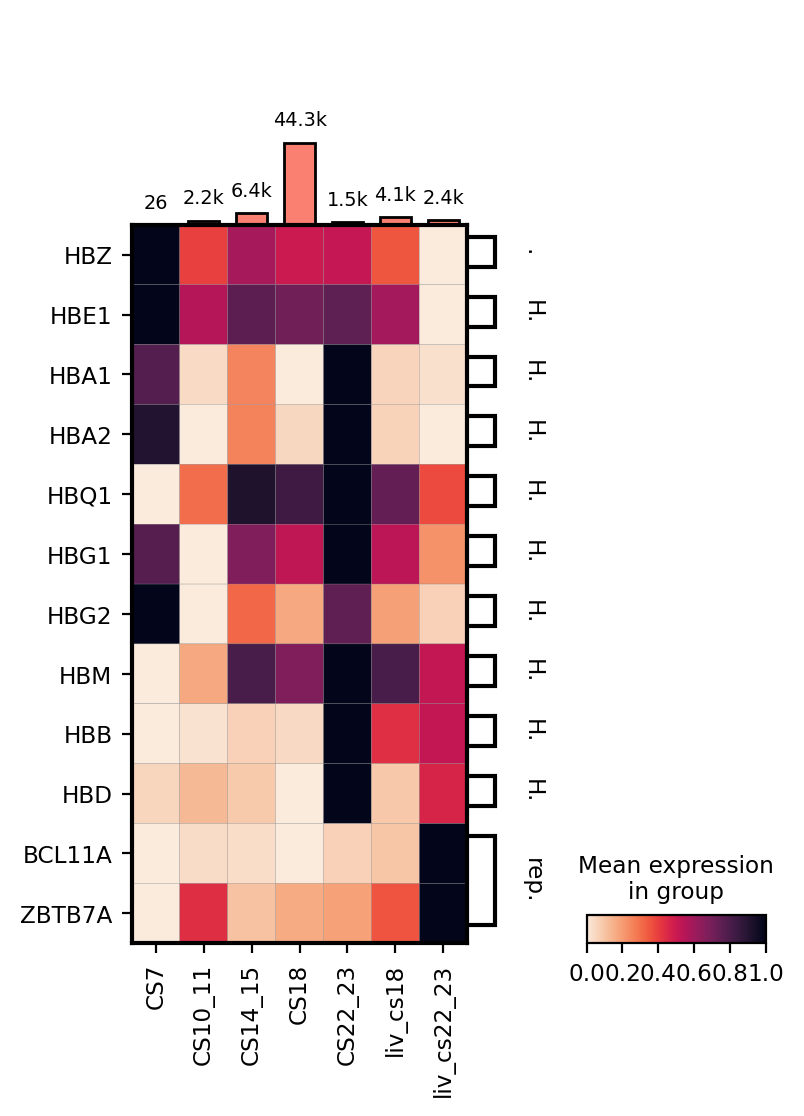

In [251]:
pl = sc.pl.matrixplot(adata, keys2, 'stage_groups',cmap = 'rocket_r',standard_scale='var',swap_axes=True,return_fig = True, vcenter=0.5, vmax=1)
pl.add_totals().show()

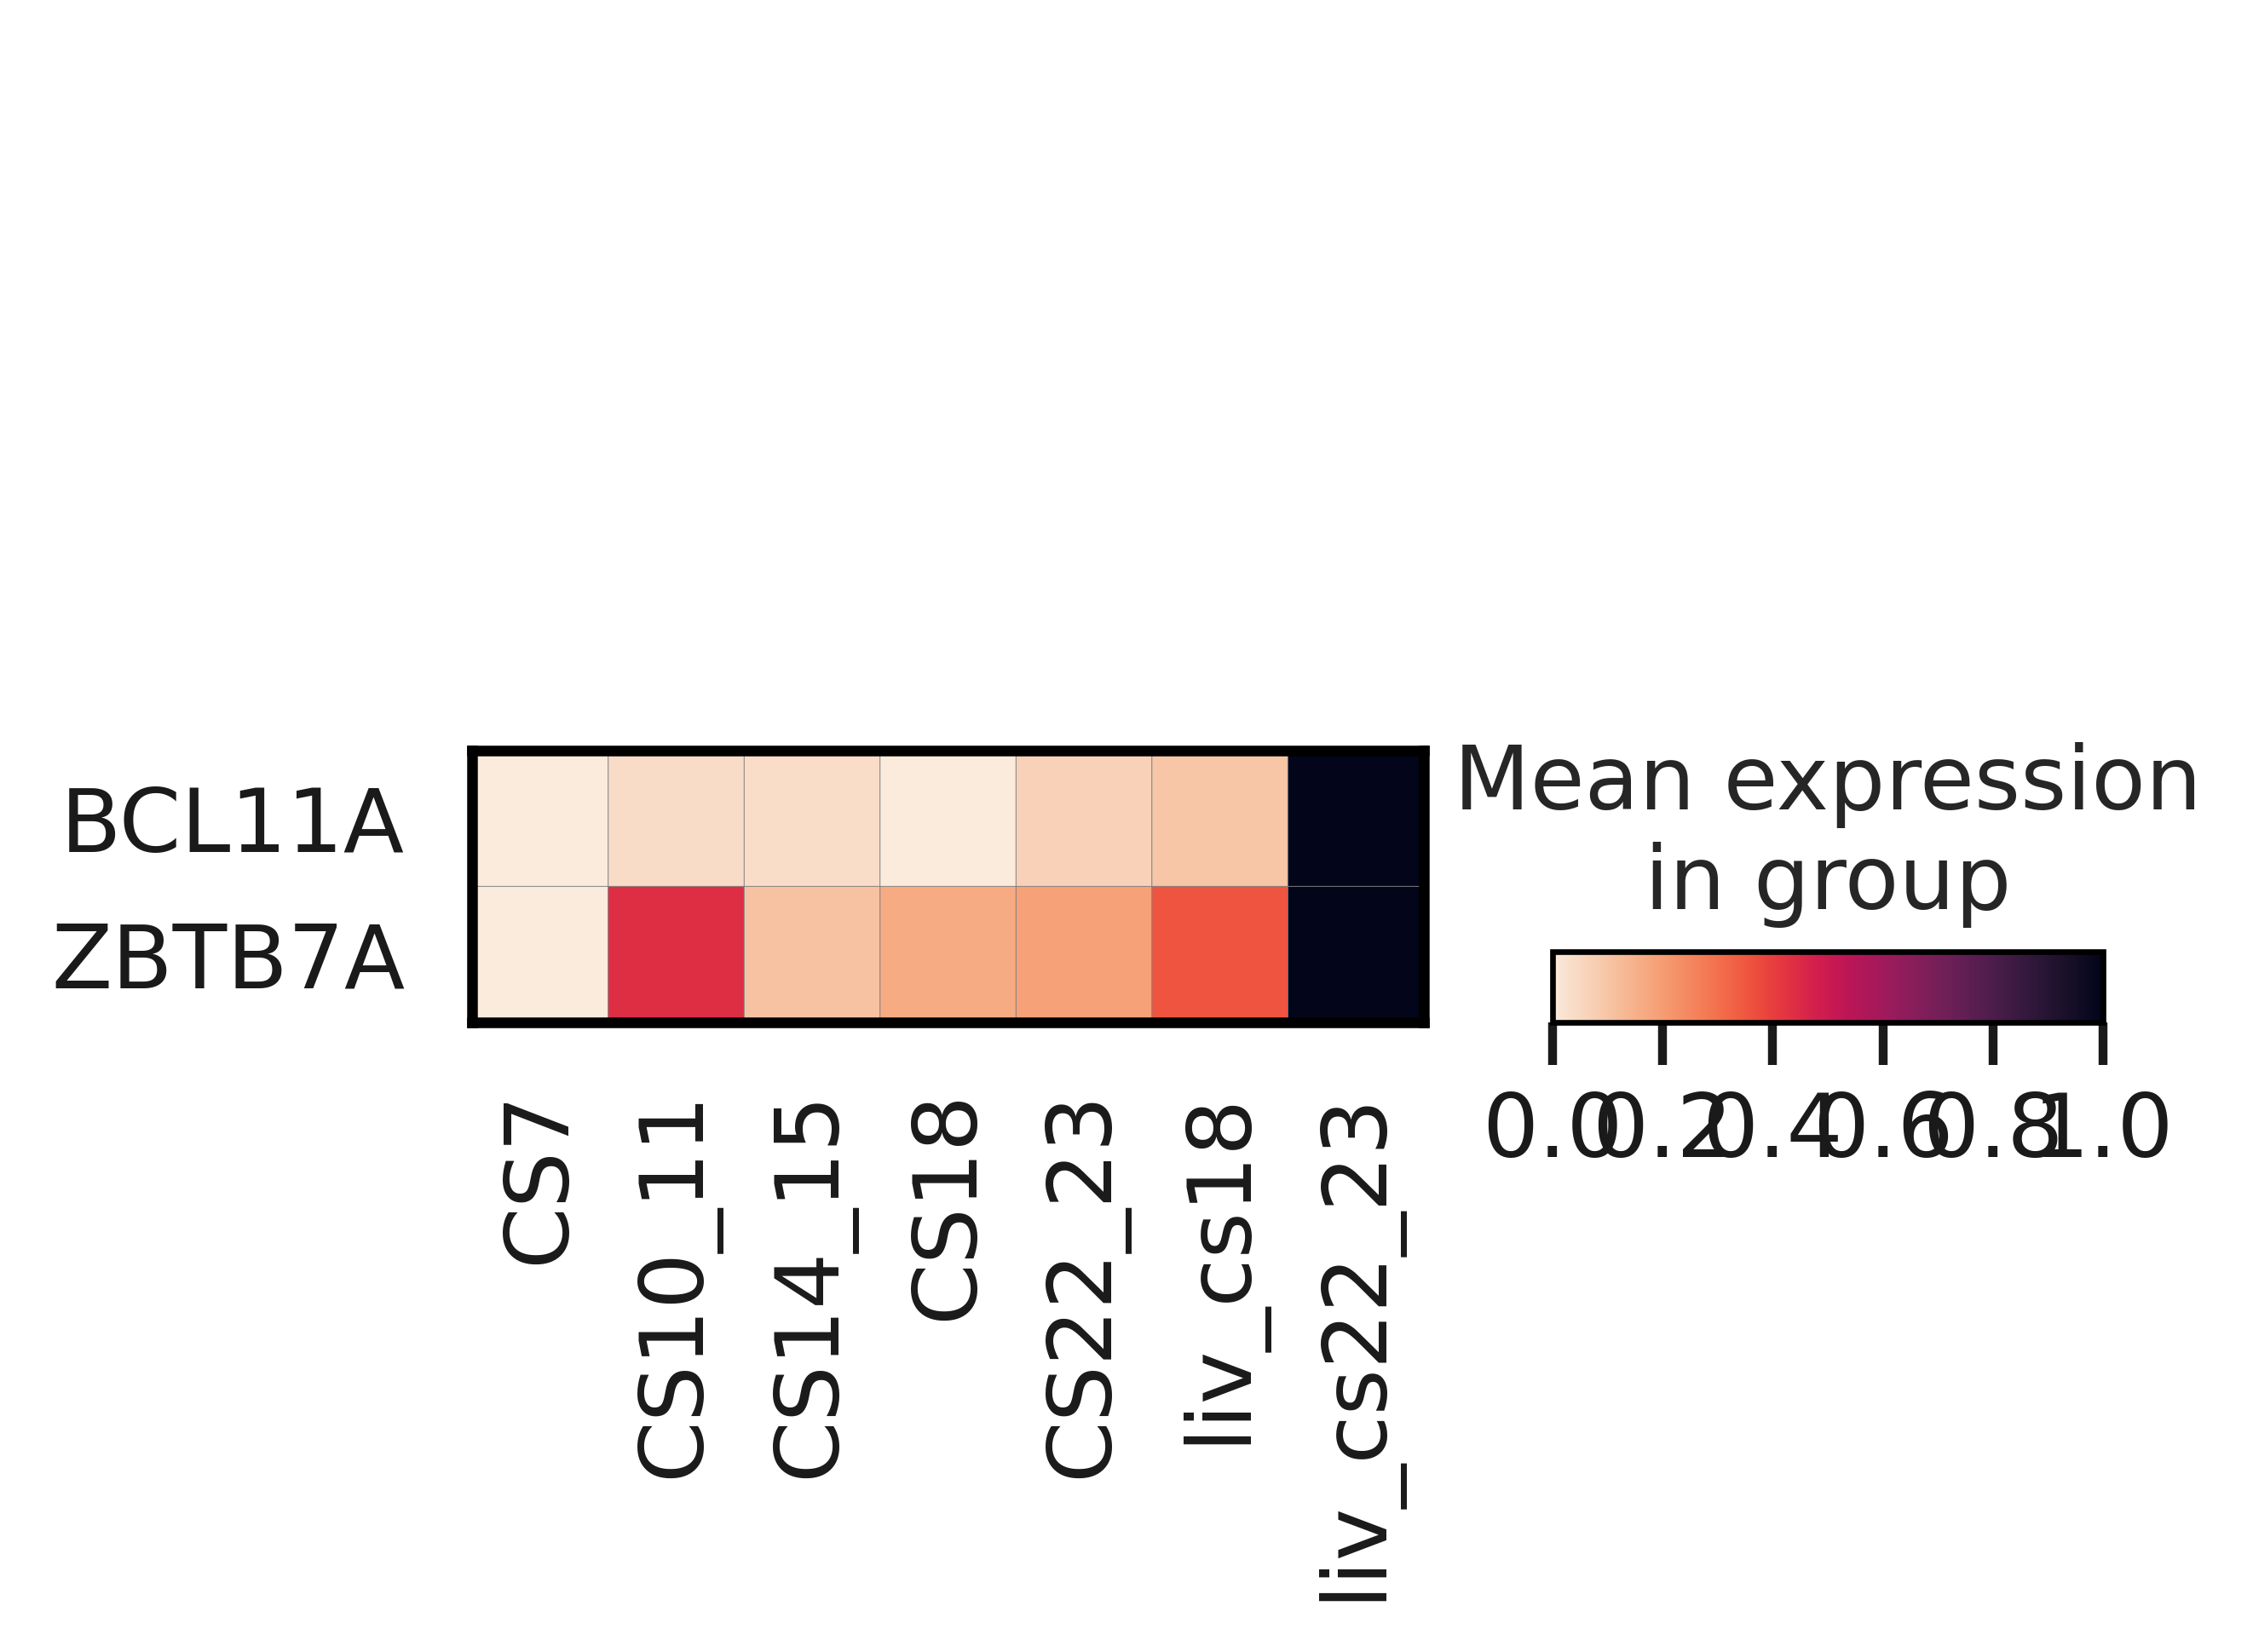

In [163]:
sc.pl.matrixplot(adata, regulators, 'stage_groups',cmap = 'rocket_r',standard_scale='var',swap_axes=True,return_fig = False, vcenter=0.5, vmax=1)

# Proportion of cells enriched in Gower1 and Gower2 genes
- Gower1

In [27]:
keys = {
'gower1':['HBZ','HBE1'],}

In [ ]:
plt.rcParams['axes.grid'] = False
threshold_val = 0
for key in keys:
#    sc.tl.score_genes(adata, [key] , ctrl_size=50, gene_pool=None, n_bins=25, score_name=('key' + '_score'), random_state=0, copy=False, use_raw=None)
    sc.tl.score_genes(adata, keys[key] , ctrl_size=100, gene_pool=None, n_bins=50, score_name=('key' + '_score'), random_state=0, copy=False, use_raw=None)
#   adata.obs['key' + '_score'] = np.sum(adata[:, keys[key]].X,axis=1)#.todense()
    #adata.obs['key' + '_score'] = adata[:, [key]].X#.todense()
    adata.obs['stage_groups'] = adata.obs['corr_concat'][:]
    adata.obs['stage_groups'] = adata.obs['stage_groups'].astype(str)
    stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15']
    groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15']
    dic = dict(zip(stages,groups))
    #YS_HSC.obs['stage_groups'] = YS_HSC.obs['stage'].map(dic)
    adata.obs.loc[adata.obs['stage'].isin(stages),'stage_groups'] = adata.obs['stage'].map(dic)
    adata.obs['stage_groups'].unique()

    stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15','F61', 'F35', 'F32']

    groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15','liv_cs18','liv_cs22_23','liv_cs22_23']
    dic = dict(zip(stages,groups))
    adata.obs['stage_groups'] = adata.obs['stage'].map(dic)
    adata.obs['stage_groups'].unique()

    # order these categories by lineage time
    ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23', 'liv_cs18', 'liv_cs22_23']
    adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

    adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Erythroid_fliv','fliv')
    adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Embryonic_fliv','fliv')      
    adata.obs['stage_groups'].unique()

    # order these categories by lineage time
    ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23','liv_cs18','liv_cs22_23']
    adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

    scores = adata.obs[['key_score','stage_groups']]
    scores.columns = ['key_score','group']
    scores_median = scores.groupby('group').median()
    scores.groupby('group').median()
    scores = scores[scores['key_score']>threshold_val]
    #scores = scores[scores['key_score']>np.mean((scores['key_score']))]
    
    
    adata.obs['is_key'] = 'False'
    adata.obs.loc[adata.obs.index.isin(scores.index),'is_key'] = "True"
    norm_count = ((adata.obs.groupby(['stage_groups','is_key'], observed=True).count()).iloc[:,1]).reset_index()
    
    count1 = ((adata.obs.groupby(['stage_groups','is_key'], observed=False).count()).iloc[:,1]).reset_index()
    count1['stage'] = count1['stage'].astype(int)
    count1['stage'] = count1['stage'] + 1
    count2 = count1[:]

    for i in count1['stage_groups'].unique():
        for z in count1.index[count1['stage_groups'].isin([i])]:
            count2.loc[count2.index.isin([z]),'stage'] = (count1.loc[count1.index.isin([z]),'stage'] / sum(count1['stage'][count1['stage_groups'].isin([i])]))*100
    #count2.set_index(['leiden_mono', 'corr_concat'], inplace=True)
    
    count4 = count2[count2['is_key'].isin(["True"])]

    norm_count = ((adata.obs.groupby(['stage_groups','is_key']).count()).iloc[:,1]).reset_index()
    norm_count = norm_count[norm_count['is_key'].isin(['True'])]
    norm_count 
    
    y1 = list(count4['stage'][count4['stage_groups'].isin(['CS7','CS10_11', 'CS22_23', 'CS14_15', 'CS18'])])
    y2 =  list(count4['stage'][count4['stage_groups'].isin(['liv_cs18','liv_cs22_23'])])
    for length in range(0,(len(y1) - len(y2))):
        y2.insert(0,np.nan)
#     y1[y1==0 ] = np.nan
#     y2[y2==0 ] = np.nan
    
    # size counts
    size_counts = np.log10(scores.groupby('group').apply(len))
    y1_size = list(size_counts[size_counts.index.isin(['CS7','CS10_11', 'CS22_23', 'CS14_15', 'CS18'])]*100)
    y2_size = list(size_counts[size_counts.index.isin(['liv_cs18','liv_cs22_23'])]*100)
    y2_size =list(np.nan_to_num(y2_size, neginf=1))
    for length in range(0,(len(y1_size) - len(y2_size))):
        y2_size.insert(0,0)
    y2_size[y2_size==0 ] = np.nan
    
    y1 = [x / 100 for x in y1]
    y2 = [x / 100 for x in y2]
    
    import matplotlib.pyplot as plt 
    from matplotlib.pyplot import figure
    #figure(figsize=(5, 10), dpi=80)
    plt.rcParams.update({'font.size': 15})
    x=['CS7', 'CS10_11', 'CS14_15', 'CS18', 'CS22_23']
#     y1 = np.log10(y1)
#     y2 = np.log10(y2)
#     y1[y1==0 ] = np.nan
#     y2[y2==0 ] = np.nan
    
    fig = plt.figure(figsize=(5, 2), dpi=200)
    ax1 = fig.add_subplot()

    ax1.scatter(x,y1,c='pink',s = y1_size ,marker='o', cmap='turbo'  ) #y1*10
    ax1.plot(x,y1,c='pink',linestyle = None)
    ax1.scatter(x,y2,c='red',s = y2_size, marker='s', cmap='turbo', )# y1*10
    ax1.plot(x,y2,c='red',linestyle = None)
    
    ymin = np.nanmin((list(y1) + list(y2)))- (np.nanmin((list(y1) + list(y2)))*0.1)
    ymax = np.nanmax((list(y1) + list(y2))) + (np.nanmax((list(y1) + list(y2)))*0.2)
    plt.grid(False)
    plt.xticks(rotation=45)
    positions = (ymin, ((ymax - ymin)/2)+ymin, ymax)
    labels = ("0", "0.5", "1")
    plt.yticks(positions, labels)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim(ymin, ymax)
    plt.title("Proportion " + key + " enriched Erythroid cells")
    plt.xticks(rotation=45)
    #plt.axhline(y=0, color='r', linestyle='-')


    # import matplotlib.lines as mlines
    # pinkcircle = mlines.Line2D([], [], color='pink', marker='o', linestyle='None',
    #                           markersize=10, label='YS')
    # redsquare = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
    #                           markersize=10, label='liv')
    # plt.legend(handles=[pinkcircle, redsquare])

    plt.savefig(("./figures/"+ key+ ".pdf"), dpi=300,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )
    plt.show()

In [126]:
keys = {
'gower2':['HBA1','HBA2','HBE1'],}

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    105 total control genes are used. (0:00:01)


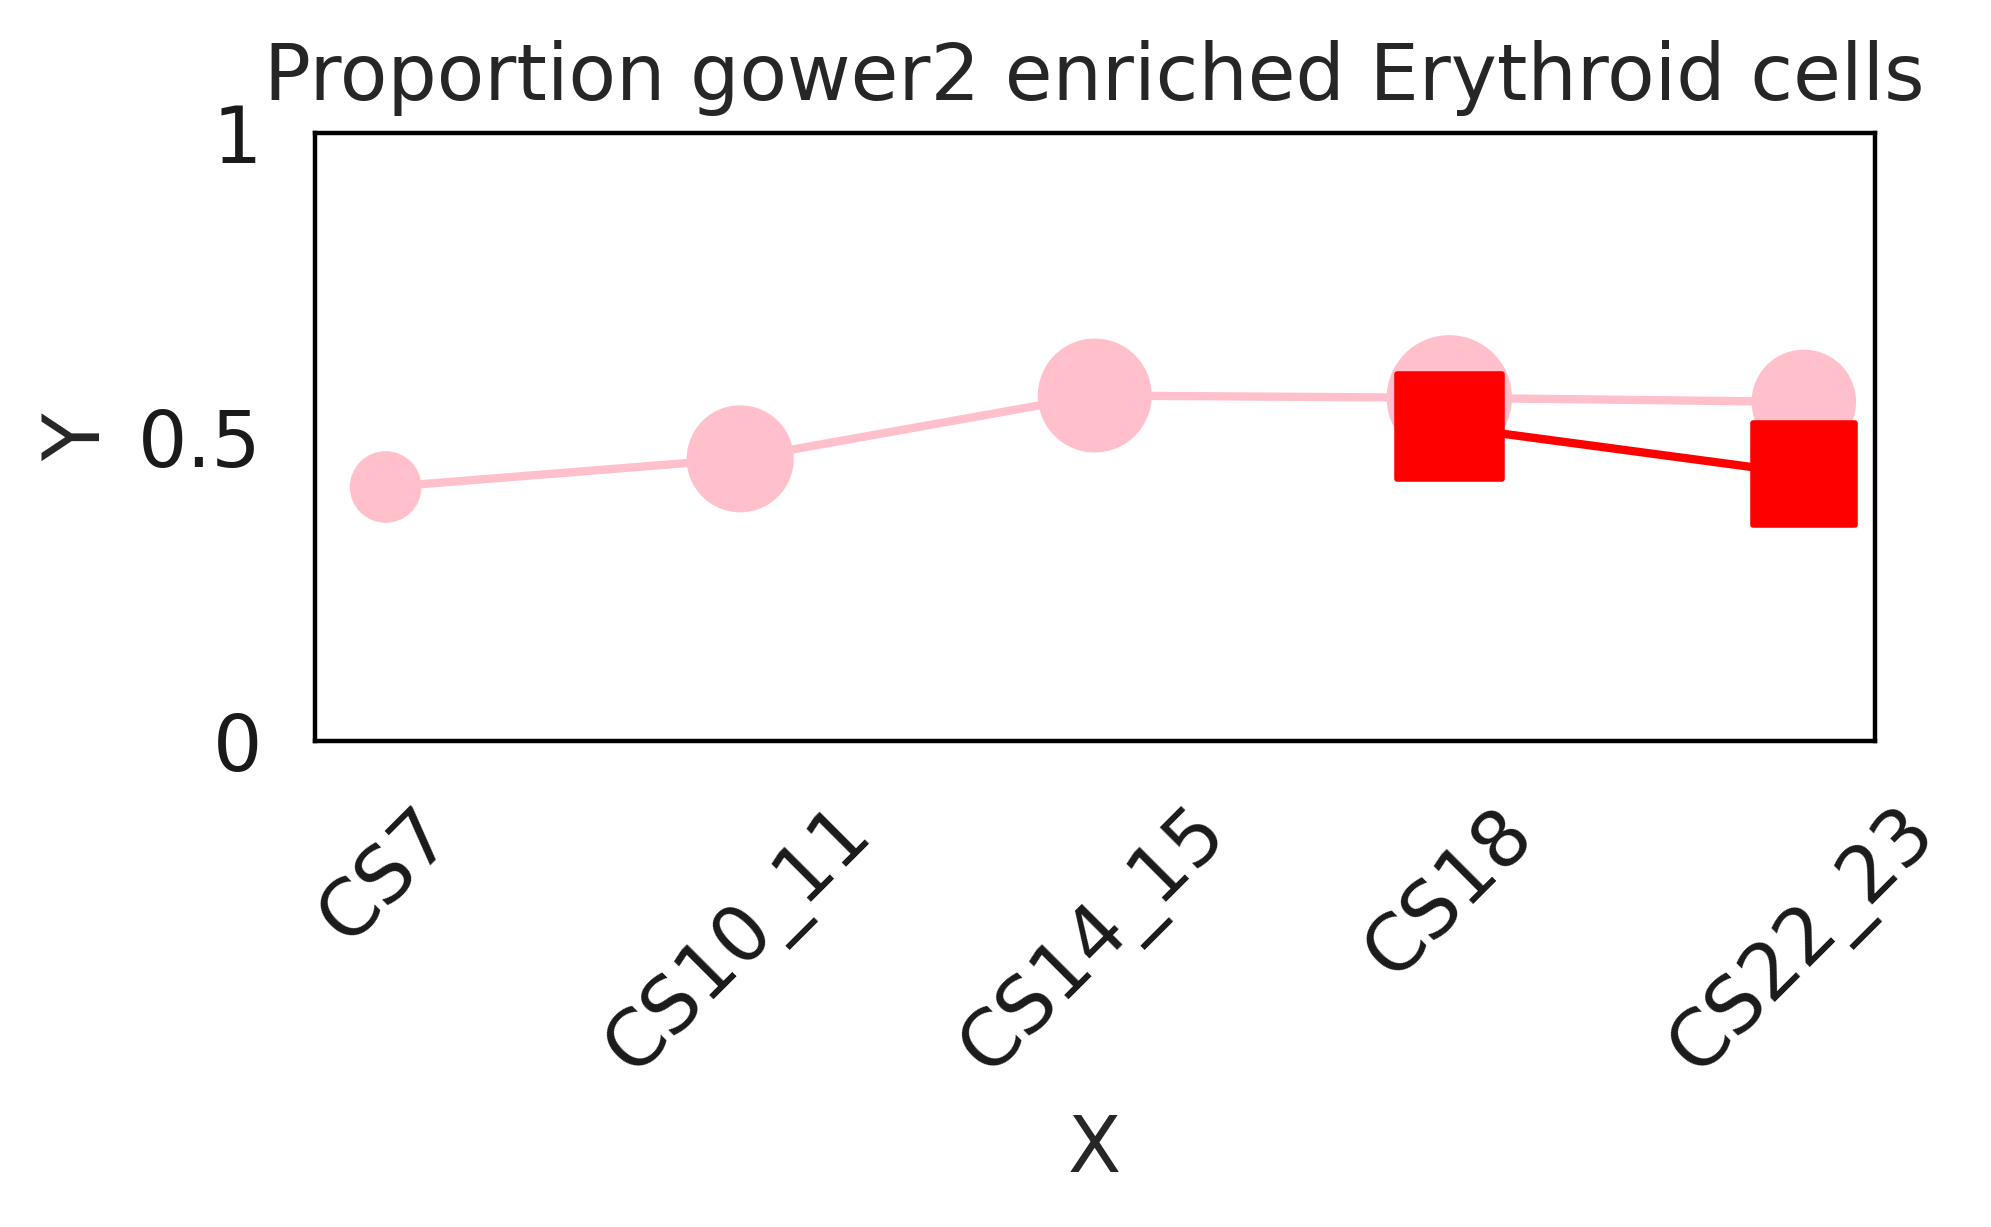

In [131]:
plt.rcParams['axes.grid'] = False
threshold_val = 0
for key in keys:
#    sc.tl.score_genes(adata, [key] , ctrl_size=50, gene_pool=None, n_bins=25, score_name=('key' + '_score'), random_state=0, copy=False, use_raw=None)
    sc.tl.score_genes(adata, keys[key] , ctrl_size=100, gene_pool=None, n_bins=50, score_name=('key' + '_score'), random_state=0, copy=False, use_raw=None)
#   adata.obs['key' + '_score'] = np.sum(adata[:, keys[key]].X,axis=1)#.todense()
    #adata.obs['key' + '_score'] = adata[:, [key]].X#.todense()
    adata.obs['stage_groups'] = adata.obs['corr_concat'][:]
    adata.obs['stage_groups'] = adata.obs['stage_groups'].astype(str)
    stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15']
    groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15']
    dic = dict(zip(stages,groups))
    #YS_HSC.obs['stage_groups'] = YS_HSC.obs['stage'].map(dic)
    adata.obs.loc[adata.obs['stage'].isin(stages),'stage_groups'] = adata.obs['stage'].map(dic)
    adata.obs['stage_groups'].unique()

    stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15','F61', 'F35', 'F32']

    groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15','liv_cs18','liv_cs22_23','liv_cs22_23']
    dic = dict(zip(stages,groups))
    adata.obs['stage_groups'] = adata.obs['stage'].map(dic)
    adata.obs['stage_groups'].unique()

    # order these categories by lineage time
    ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23', 'liv_cs18', 'liv_cs22_23']
    adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

    adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Erythroid_fliv','fliv')
    adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Embryonic_fliv','fliv')      
    adata.obs['stage_groups'].unique()

    # order these categories by lineage time
    ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23','liv_cs18','liv_cs22_23']
    adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

    scores = adata.obs[['key_score','stage_groups']]
    scores.columns = ['key_score','group']
    scores_median = scores.groupby('group').median()
    scores.groupby('group').median()
    scores = scores[scores['key_score']>threshold_val]
    #scores = scores[scores['key_score']>np.mean((scores['key_score']))]
    
    
    adata.obs['is_key'] = 'False'
    adata.obs.loc[adata.obs.index.isin(scores.index),'is_key'] = "True"
    norm_count = ((adata.obs.groupby(['stage_groups','is_key'], observed=True).count()).iloc[:,1]).reset_index()
    
    count1 = ((adata.obs.groupby(['stage_groups','is_key'], observed=False).count()).iloc[:,1]).reset_index()
    count1['stage'] = count1['stage'].astype(int)
    count1['stage'] = count1['stage'] + 1
    count2 = count1[:]

    for i in count1['stage_groups'].unique():
        for z in count1.index[count1['stage_groups'].isin([i])]:
            count2.loc[count2.index.isin([z]),'stage'] = (count1.loc[count1.index.isin([z]),'stage'] / sum(count1['stage'][count1['stage_groups'].isin([i])]))*100
    #count2.set_index(['leiden_mono', 'corr_concat'], inplace=True)
    
    count4 = count2[count2['is_key'].isin(["True"])]

    norm_count = ((adata.obs.groupby(['stage_groups','is_key']).count()).iloc[:,1]).reset_index()
    norm_count = norm_count[norm_count['is_key'].isin(['True'])]
    norm_count 
    
    y1 = list(count4['stage'][count4['stage_groups'].isin(['CS7','CS10_11', 'CS22_23', 'CS14_15', 'CS18'])])
    y2 =  list(count4['stage'][count4['stage_groups'].isin(['liv_cs18','liv_cs22_23'])])
    for length in range(0,(len(y1) - len(y2))):
        y2.insert(0,np.nan)
#     y1[y1==0 ] = np.nan
#     y2[y2==0 ] = np.nan
    
    # size counts
    size_counts = np.log10(scores.groupby('group').apply(len))
    y1_size = list(size_counts[size_counts.index.isin(['CS7','CS10_11', 'CS22_23', 'CS14_15', 'CS18'])]*100)
    y2_size = list(size_counts[size_counts.index.isin(['liv_cs18','liv_cs22_23'])]*100)
    y2_size =list(np.nan_to_num(y2_size, neginf=1))
    for length in range(0,(len(y1_size) - len(y2_size))):
        y2_size.insert(0,0)
    y2_size[y2_size==0 ] = np.nan
    
    y1 = [x / 100 for x in y1]
    y2 = [x / 100 for x in y2]
    
    import matplotlib.pyplot as plt 
    from matplotlib.pyplot import figure
    #figure(figsize=(5, 10), dpi=80)
    plt.rcParams.update({'font.size': 15})
    x=['CS7', 'CS10_11', 'CS14_15', 'CS18', 'CS22_23']
#     y1 = np.log10(y1)
#     y2 = np.log10(y2)
#     y1[y1==0 ] = np.nan
#     y2[y2==0 ] = np.nan
    
    fig = plt.figure(figsize=(5, 2), dpi=200)
    ax1 = fig.add_subplot()

    ax1.plot(x,y2,c='red',linestyle = None)
    ax1.plot(x,y1,c='pink',linestyle = None)
    ax1.scatter(x,y1,c='pink',s = y1_size ,marker='o', cmap='turbo',zorder=10  ) #y1*10
    ax1.scatter(x,y2,c='red',s = y2_size, marker='s', cmap='turbo',zorder=10 )# y1*10
    
    
    ymin = np.nanmin((list(y1) + list(y2)))- (np.nanmin((list(y1) + list(y2)))*0.1)
    ymax = np.nanmax((list(y1) + list(y2))) + (np.nanmax((list(y1) + list(y2)))*0.1)
    plt.grid(False)
    plt.xticks(rotation=45)
    positions = (ymin, ((ymax - ymin)/2)+ymin, ymax)
    labels = ("0", "0.5", "1")
    plt.yticks(positions, labels)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim(ymin, ymax)
    plt.title("Proportion " + key + " enriched Erythroid cells")
    plt.xticks(rotation=45)
    #plt.axhline(y=0, color='r', linestyle='-')


    # import matplotlib.lines as mlines
    # pinkcircle = mlines.Line2D([], [], color='pink', marker='o', linestyle='None',
    #                           markersize=10, label='YS')
    # redsquare = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
    #                           markersize=10, label='liv')
    # plt.legend(handles=[pinkcircle, redsquare])

    plt.savefig(("./figures/"+ key+ ".pdf"), dpi=300,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )
    plt.show()

# Plot each gene individually

In [23]:
keys = { 'HBZ':['HBZ'],
 'HBE1':['HBE1'],
 'HBA1':['HBA1'],
 'HBA2':['HBA2'],
 'HBQ1':[ 'HBQ1'], 
 'HBG1':['HBG1'],
 'HBG2':['HBG2'],
 'HBM':['HBM'],
 'HBB':['HBB'],
 'HBD':['HBD'],
'BCL11A':['BCL11A'],
 'ZBTB7A':['ZBTB7A']
       }

In [63]:
count4

stage_groups is_key      stage
1           CS7   True  17.857143
3       CS10_11   True  15.484159
5       CS14_15   True   6.933624
7          CS18   True   2.492324
9       CS22_23   True  29.079919
11     liv_cs18   True   6.514818
13  liv_cs22_23   True  34.995844

In [62]:
import pymannkendall as mk

In [66]:
y1

[0.17857142857142858,
 0.15484158857652833,
 0.06933624181988159,
 0.02492324363373668,
 0.2907991940899933]

In [72]:
trend = mk.original_test(y1)
p = trend.p
z = trend.z

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    7 total control genes are used. (0:00:01)


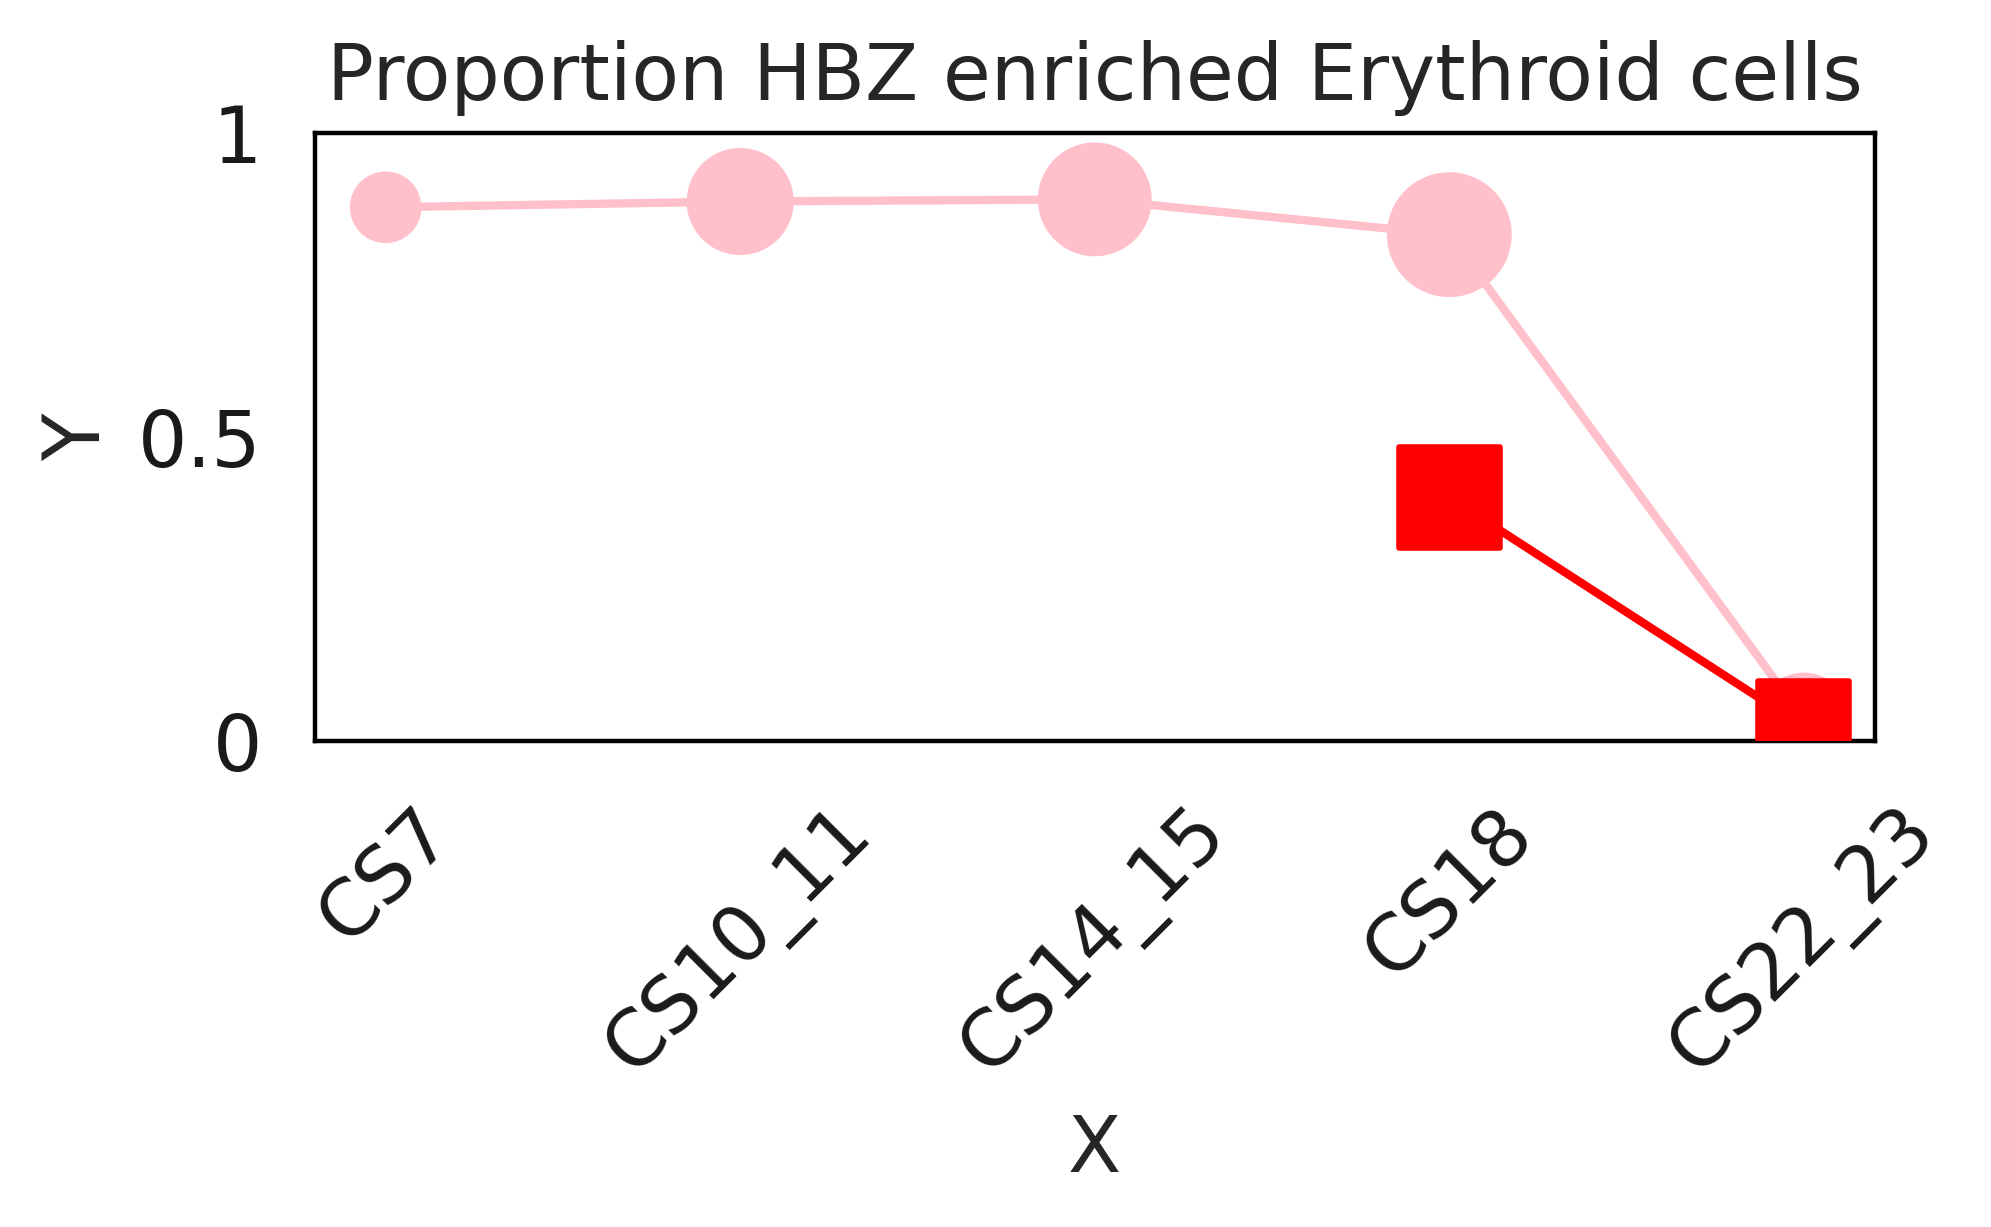

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    7 total control genes are used. (0:00:01)


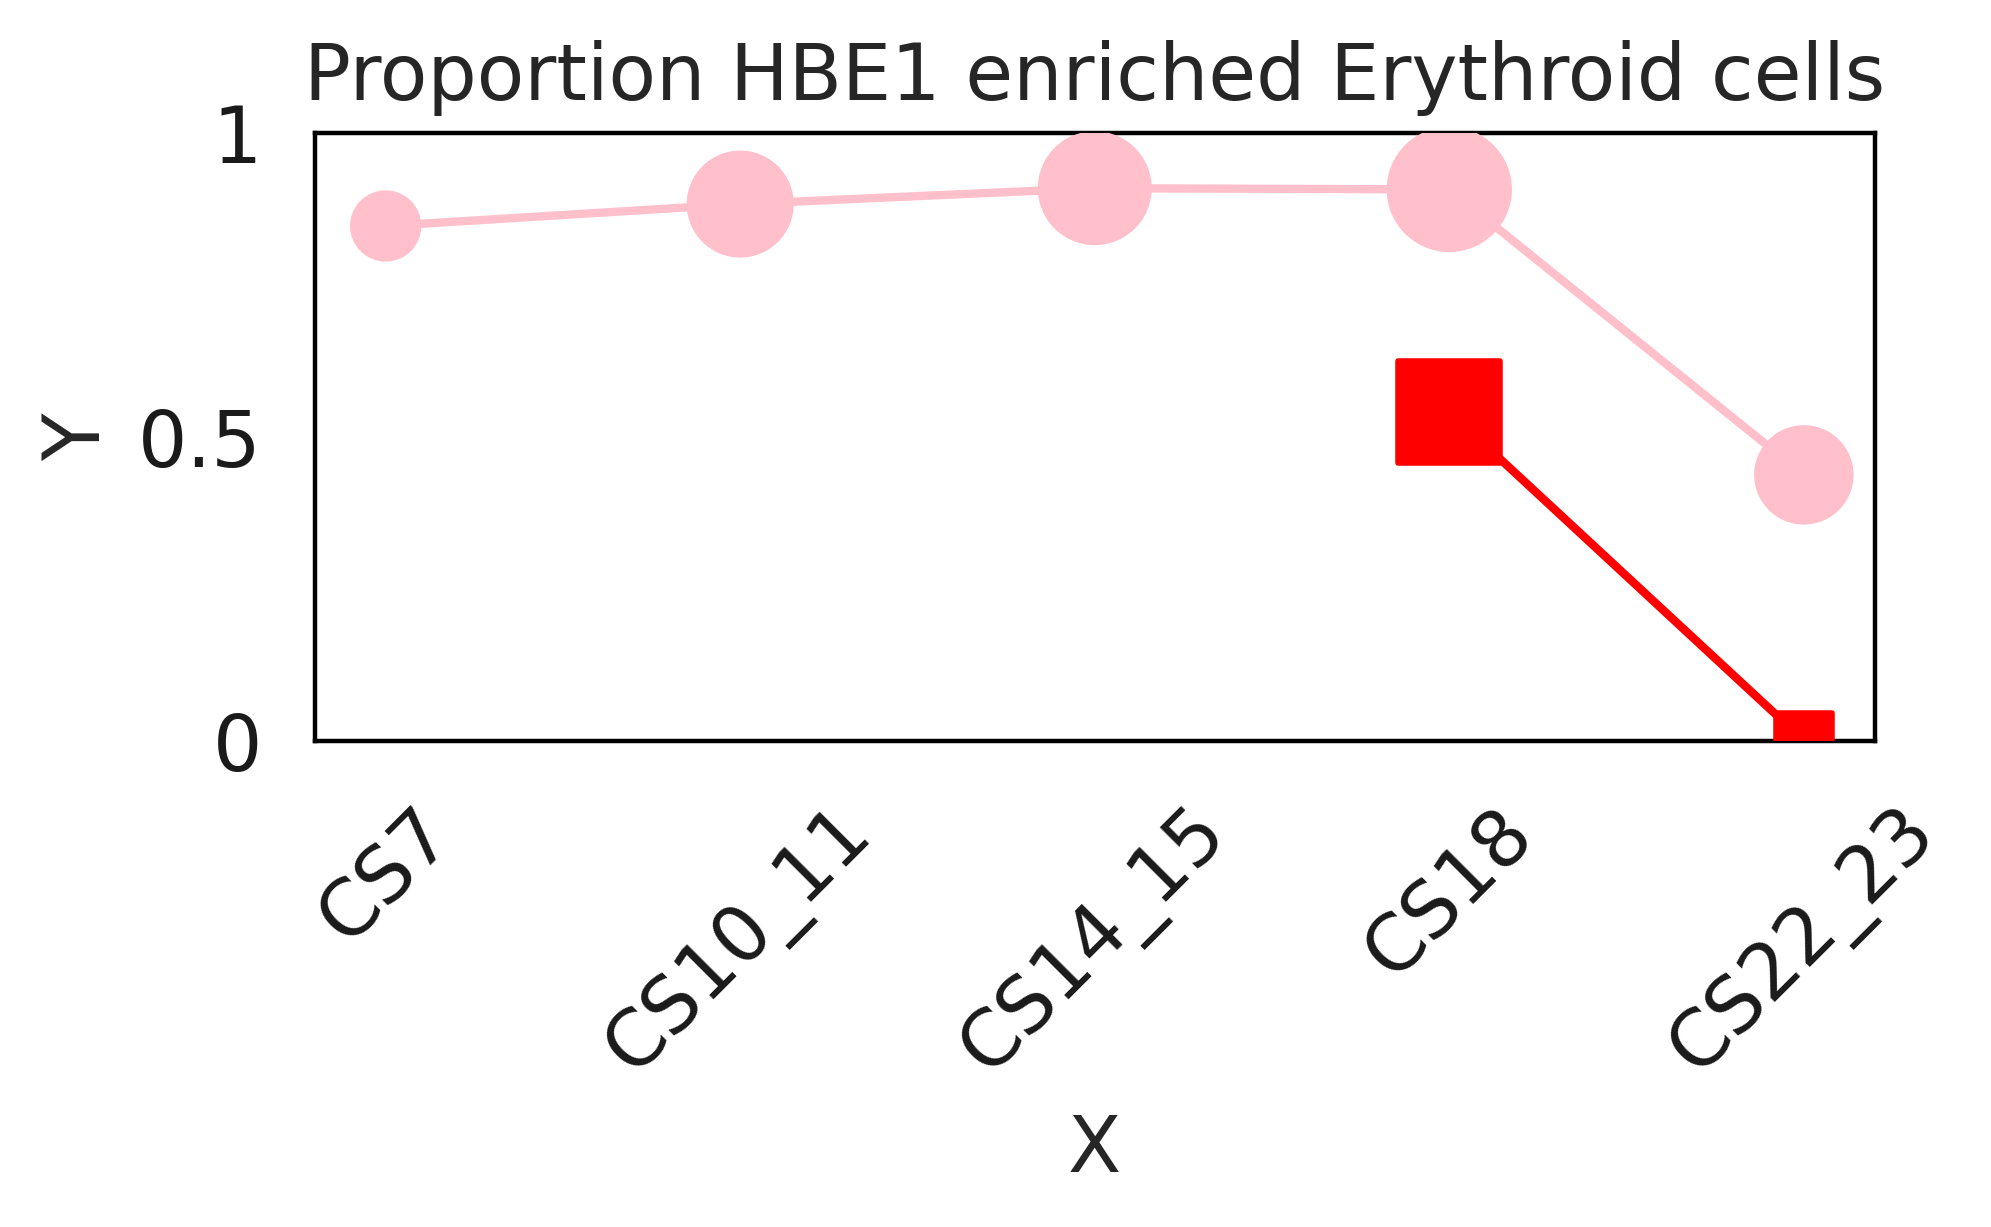

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:01)


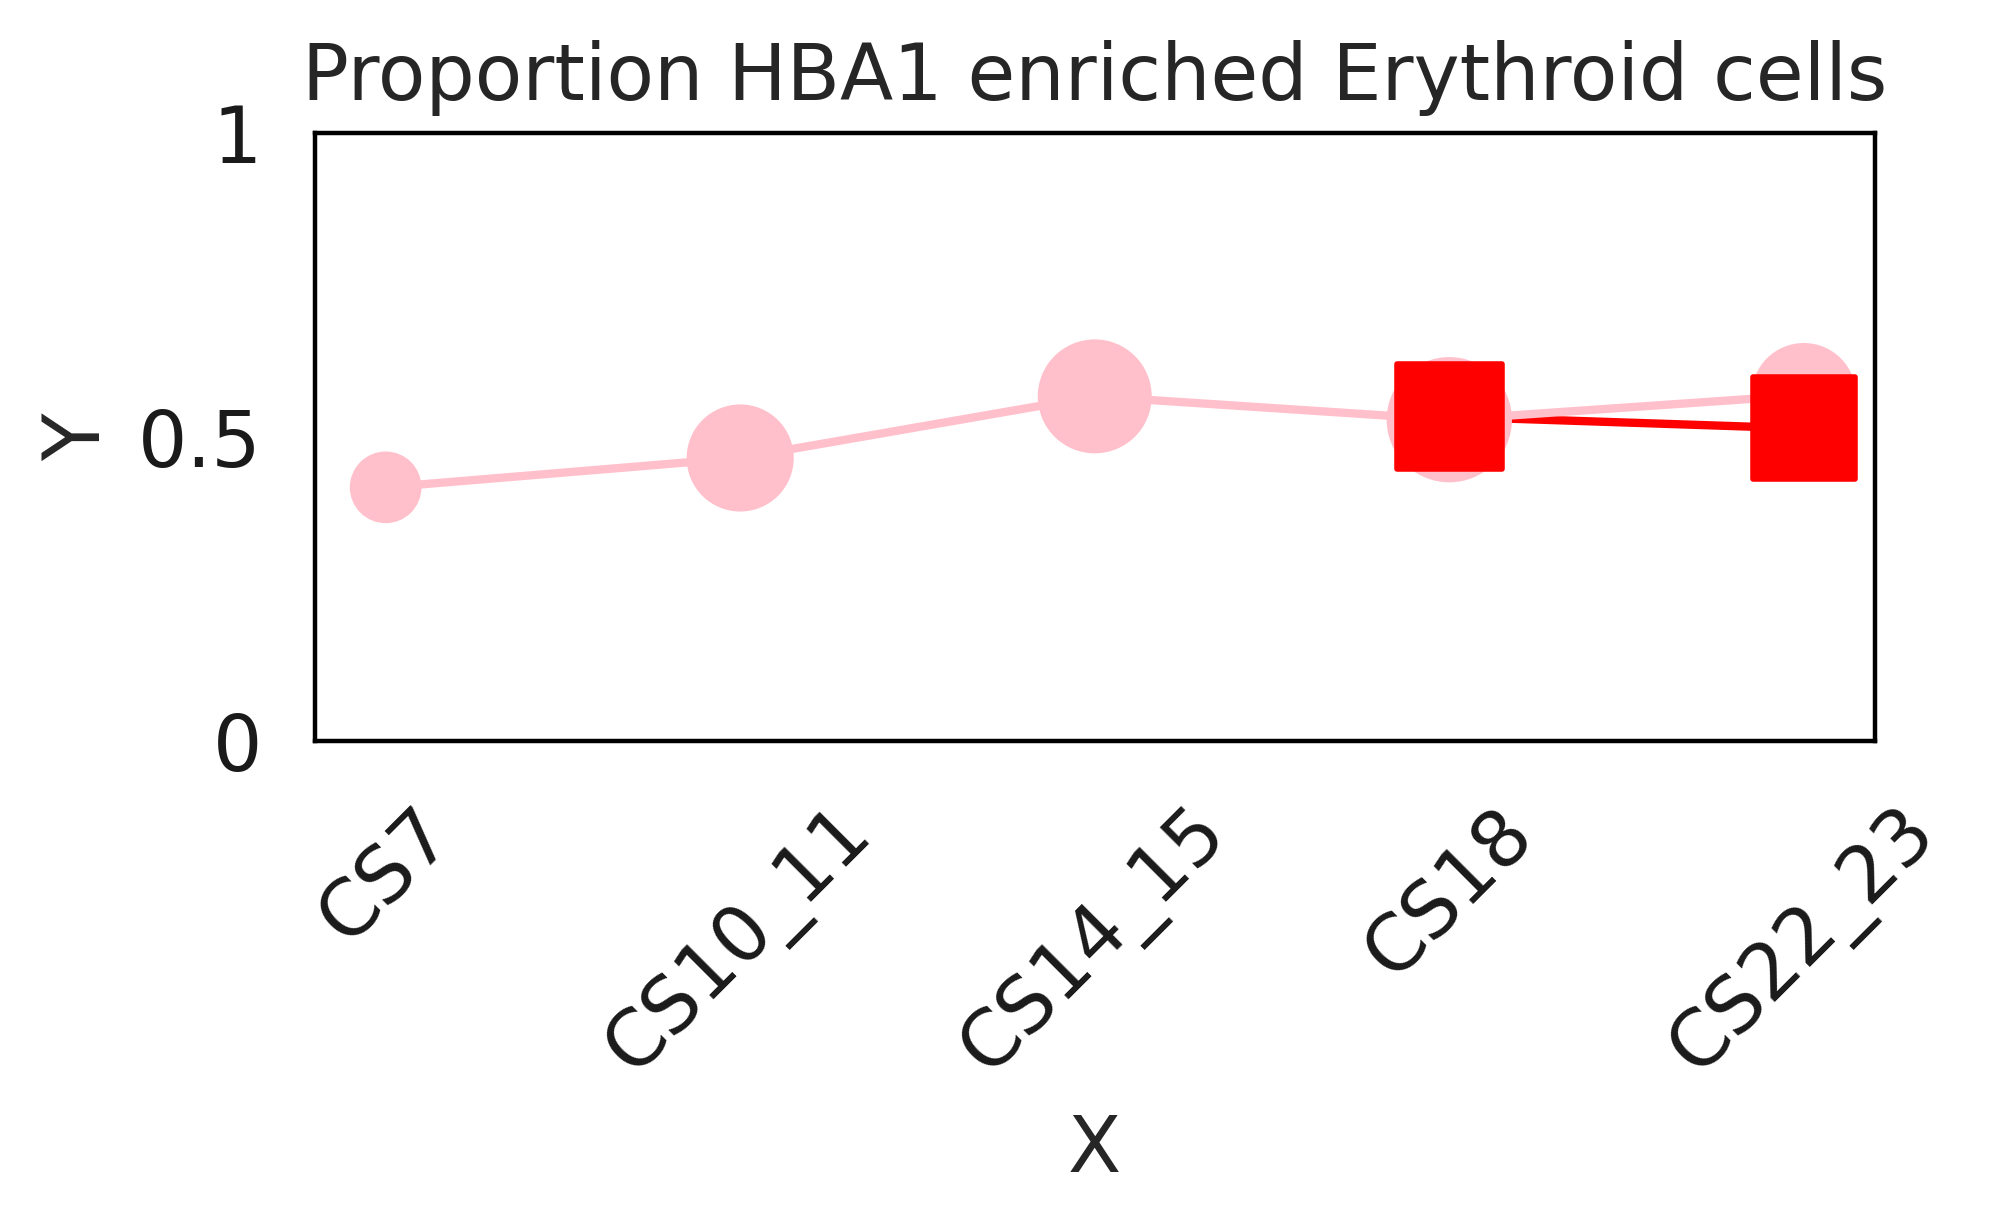

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    7 total control genes are used. (0:00:01)


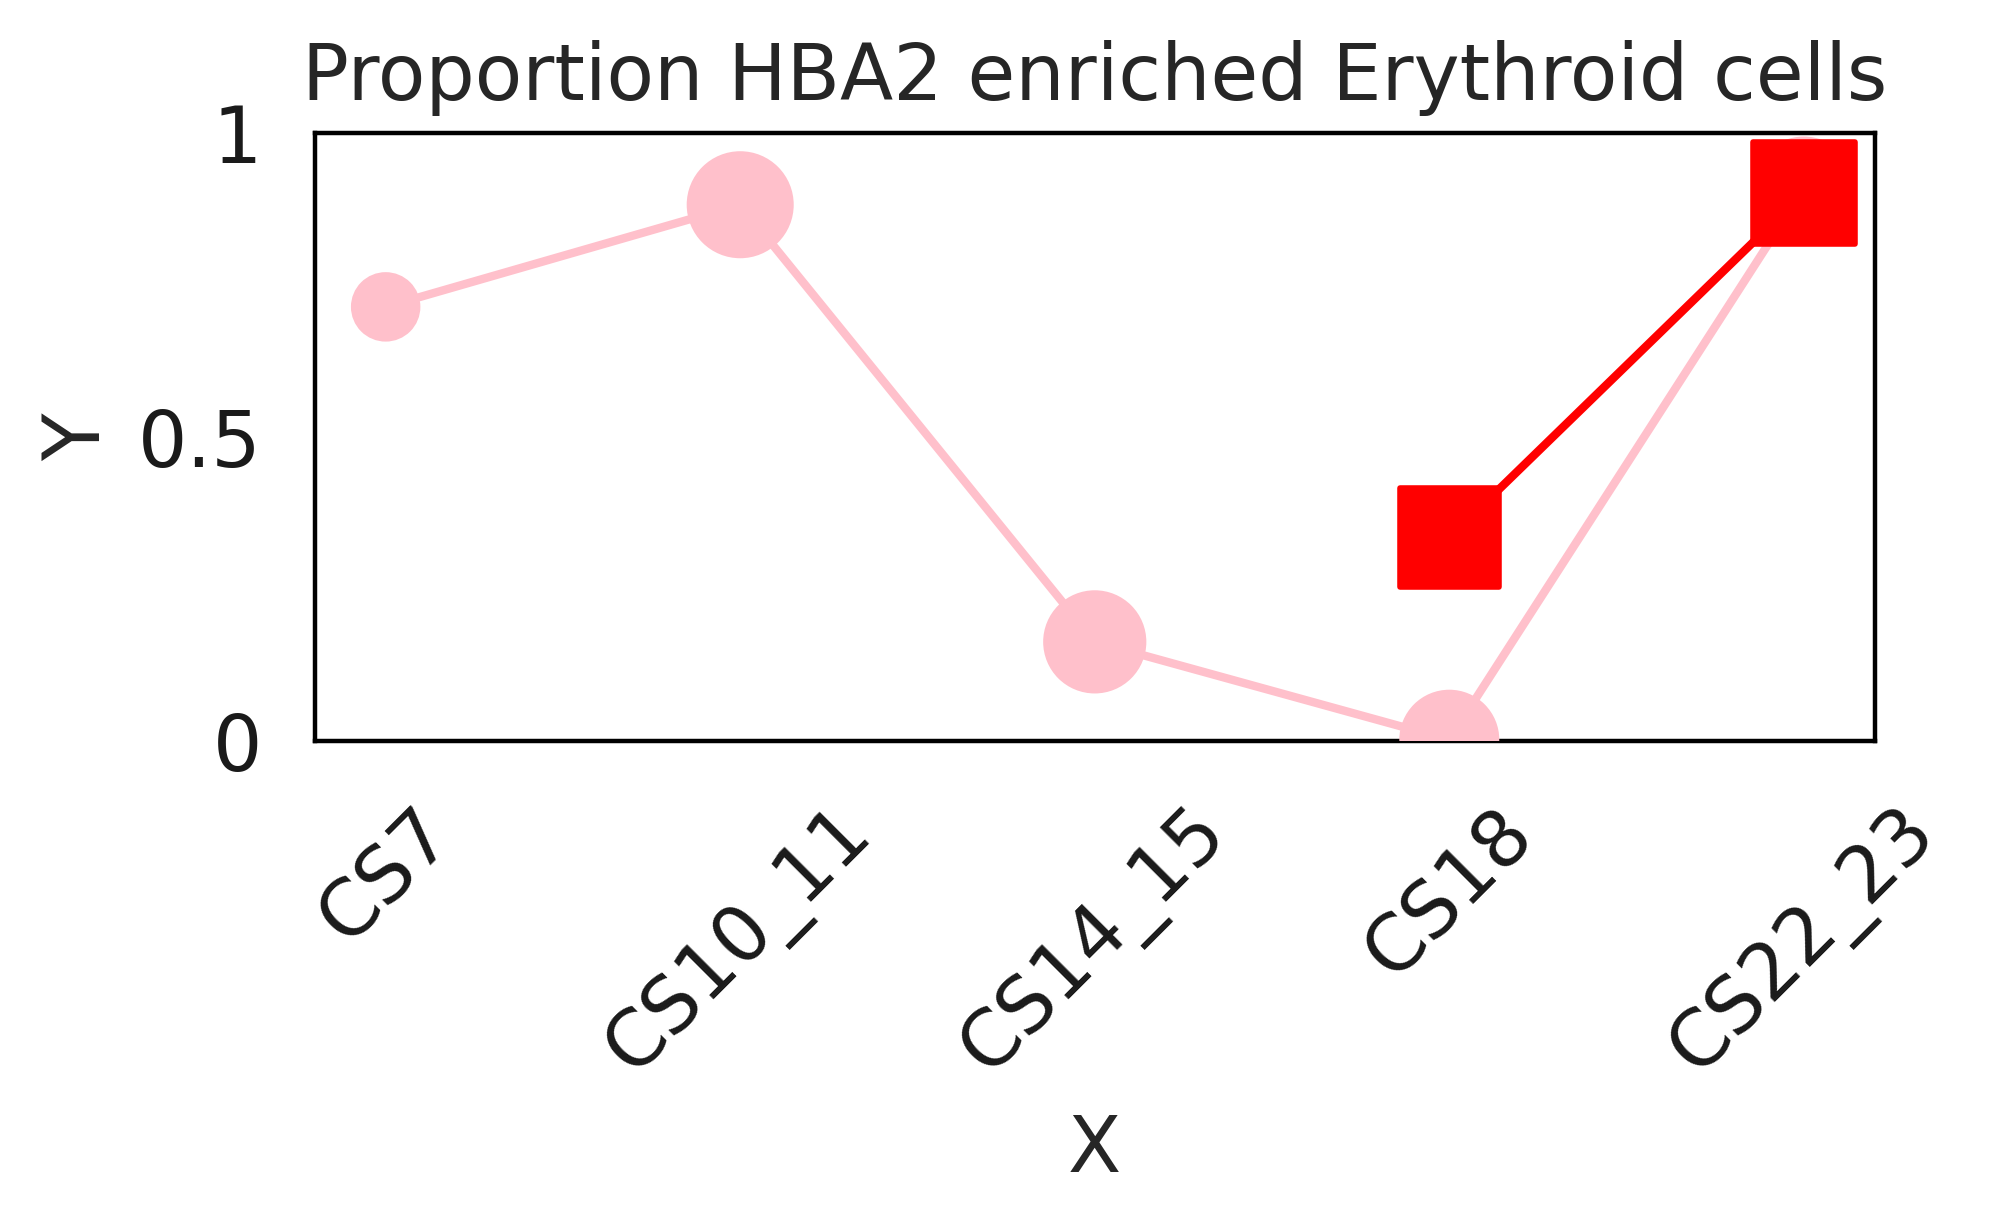

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


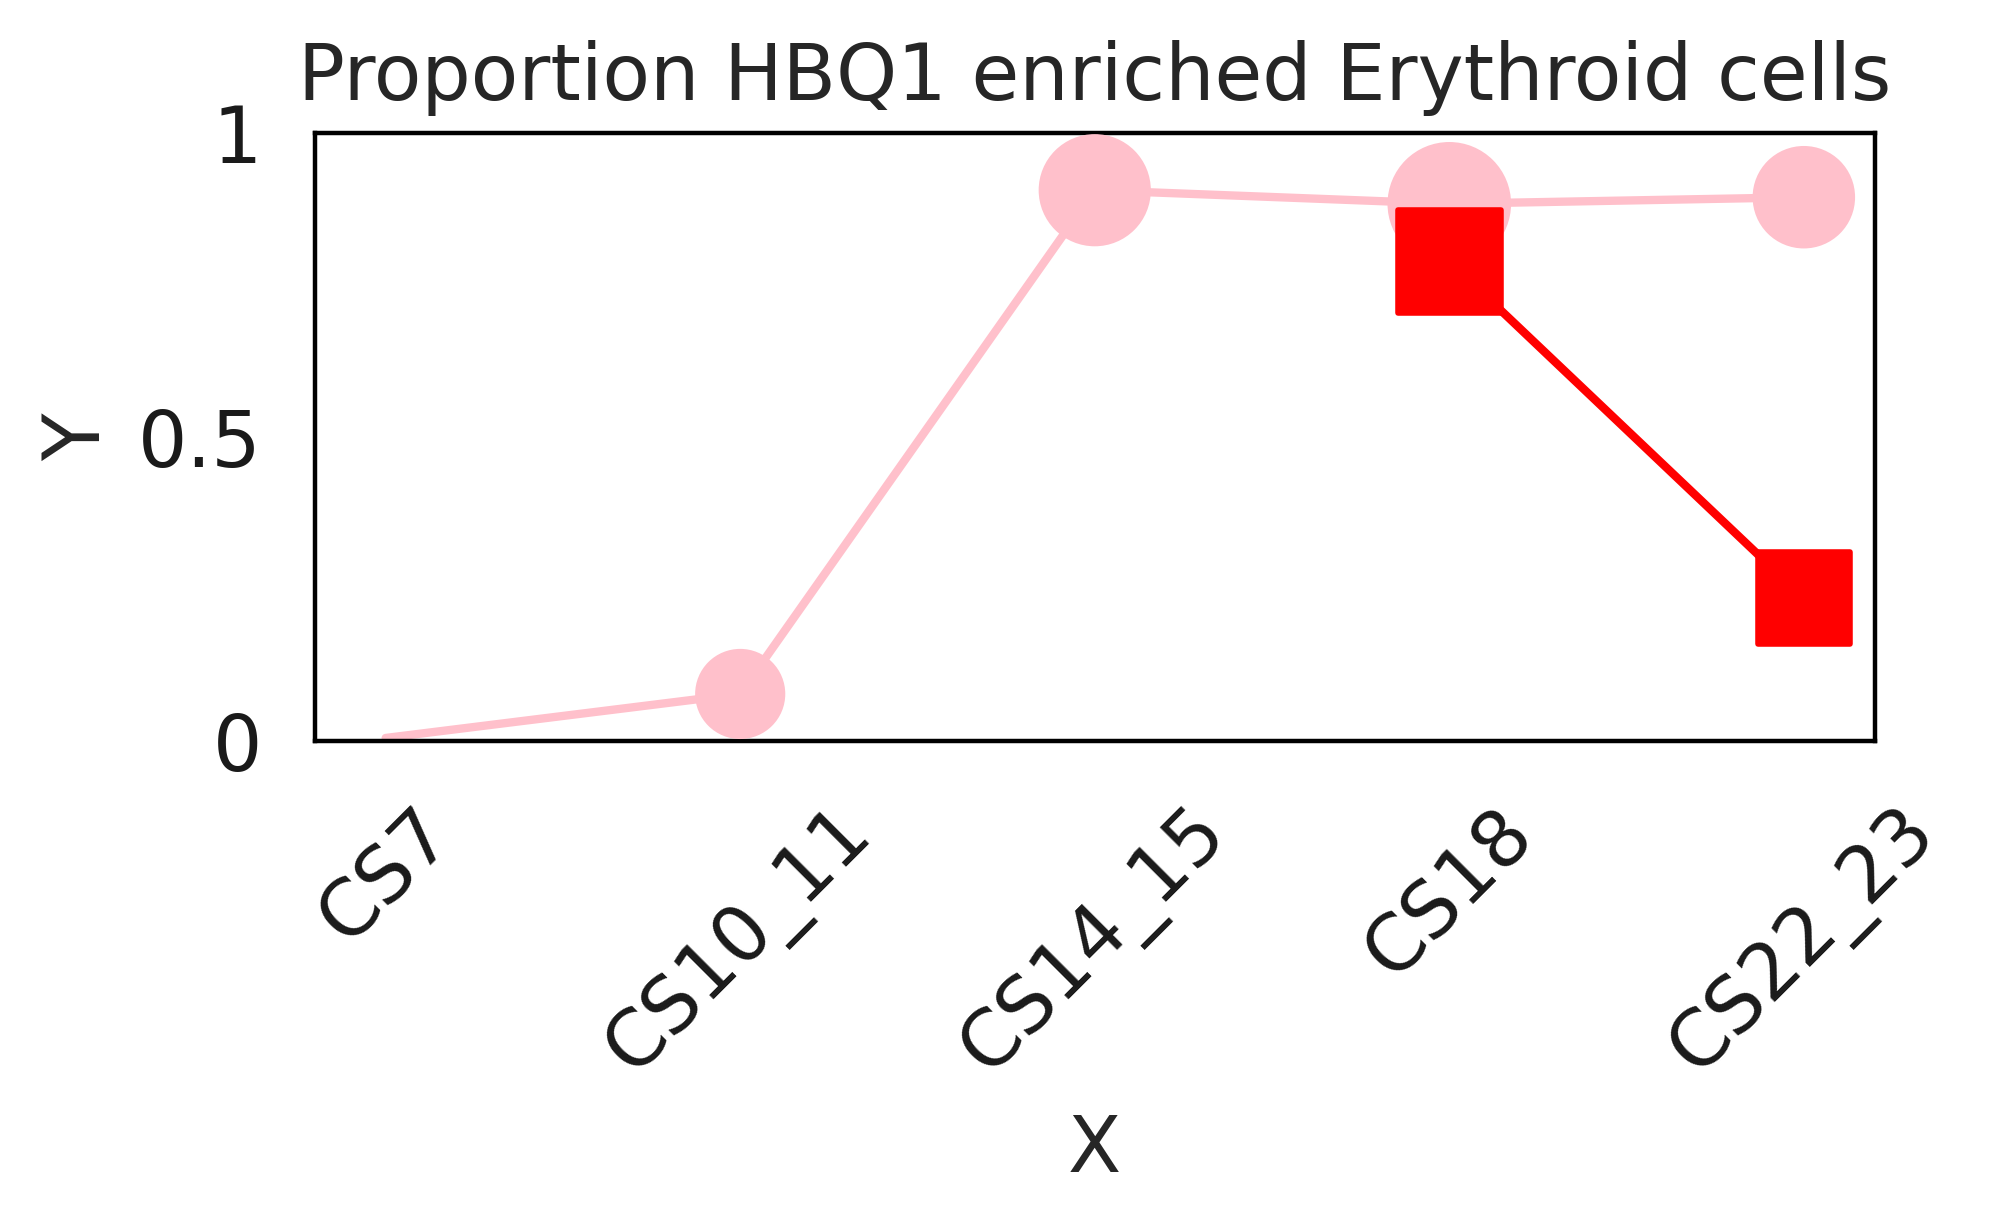

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    7 total control genes are used. (0:00:01)


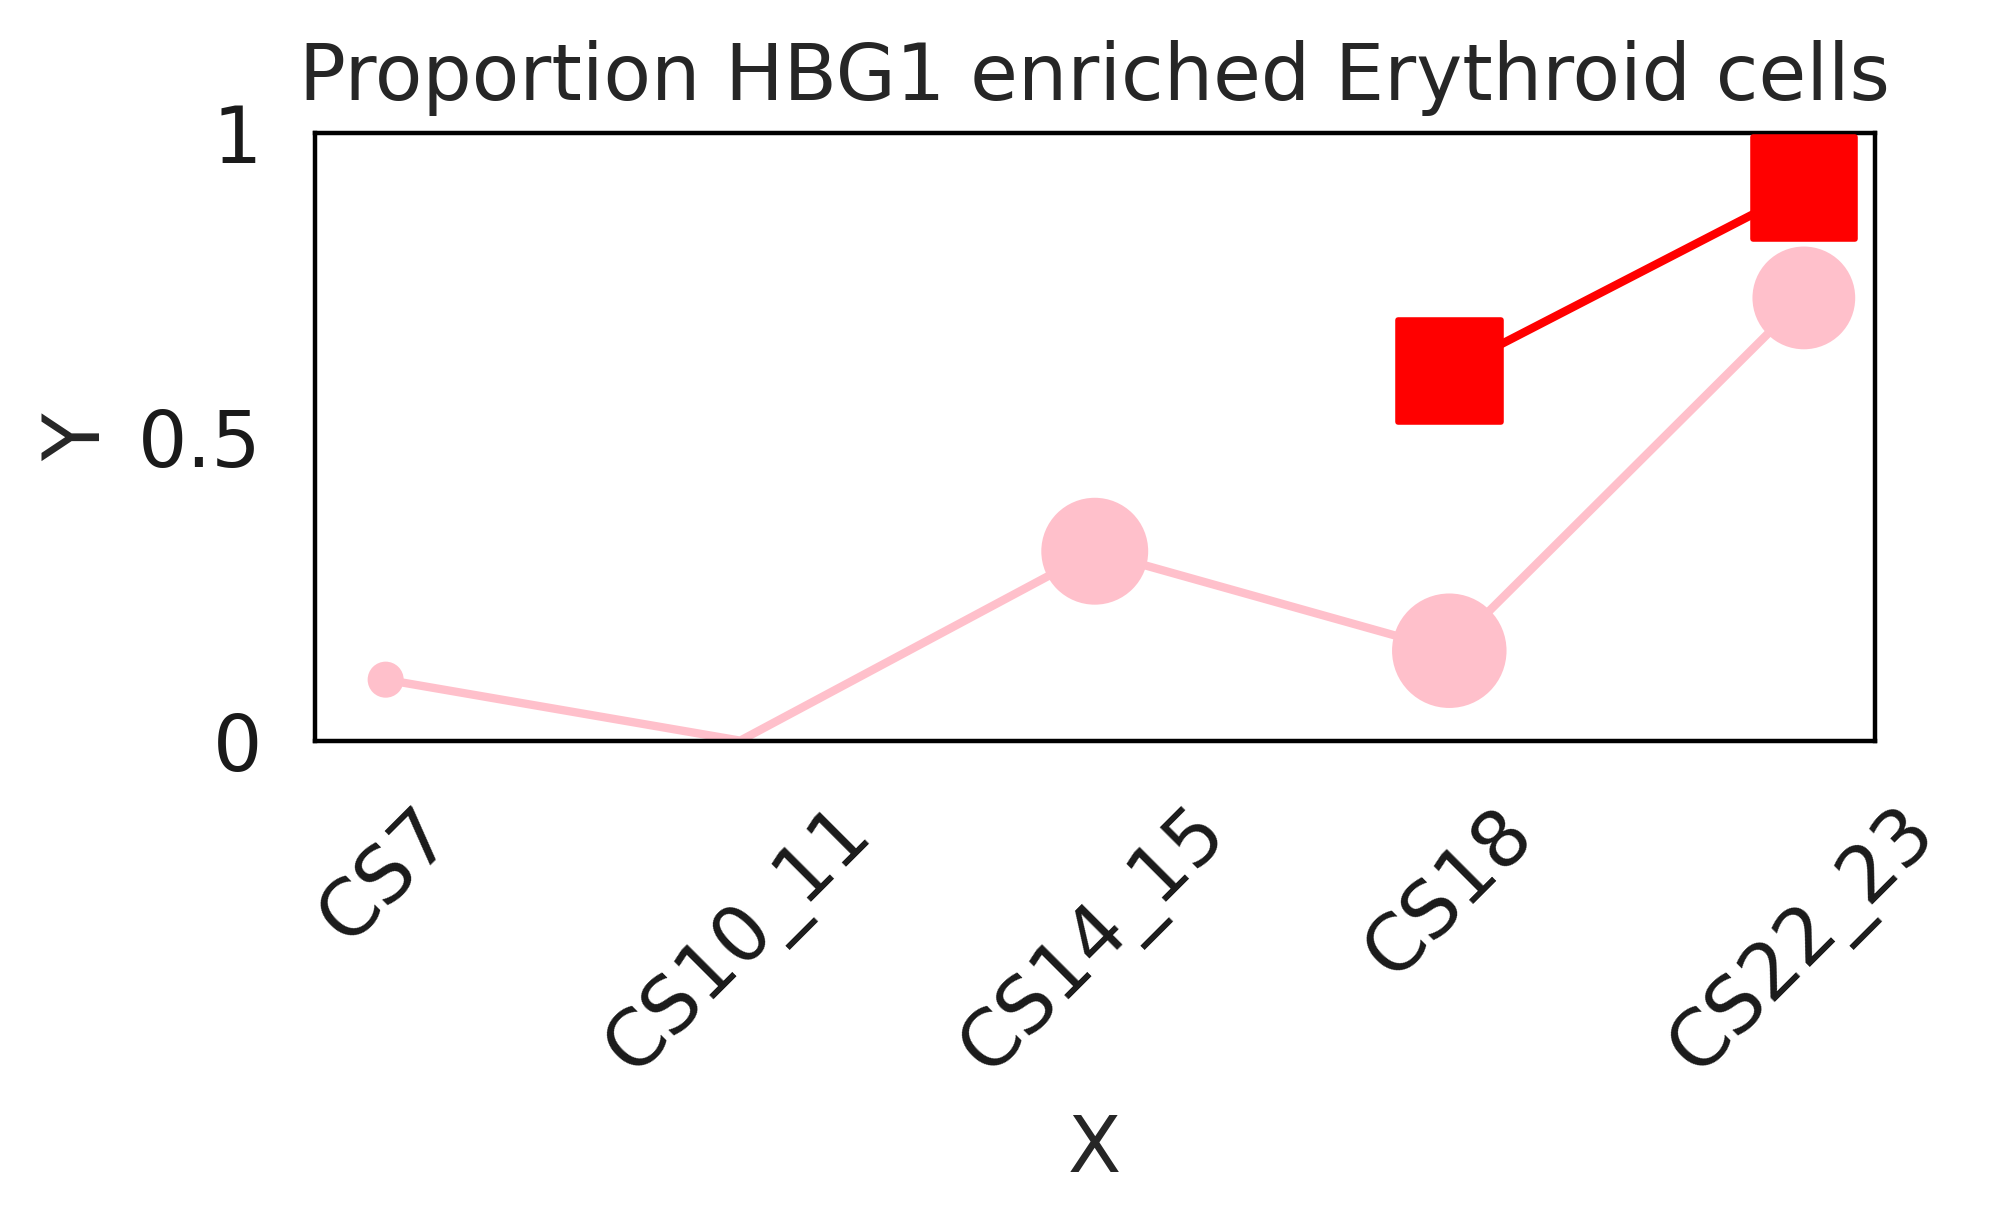

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    7 total control genes are used. (0:00:01)


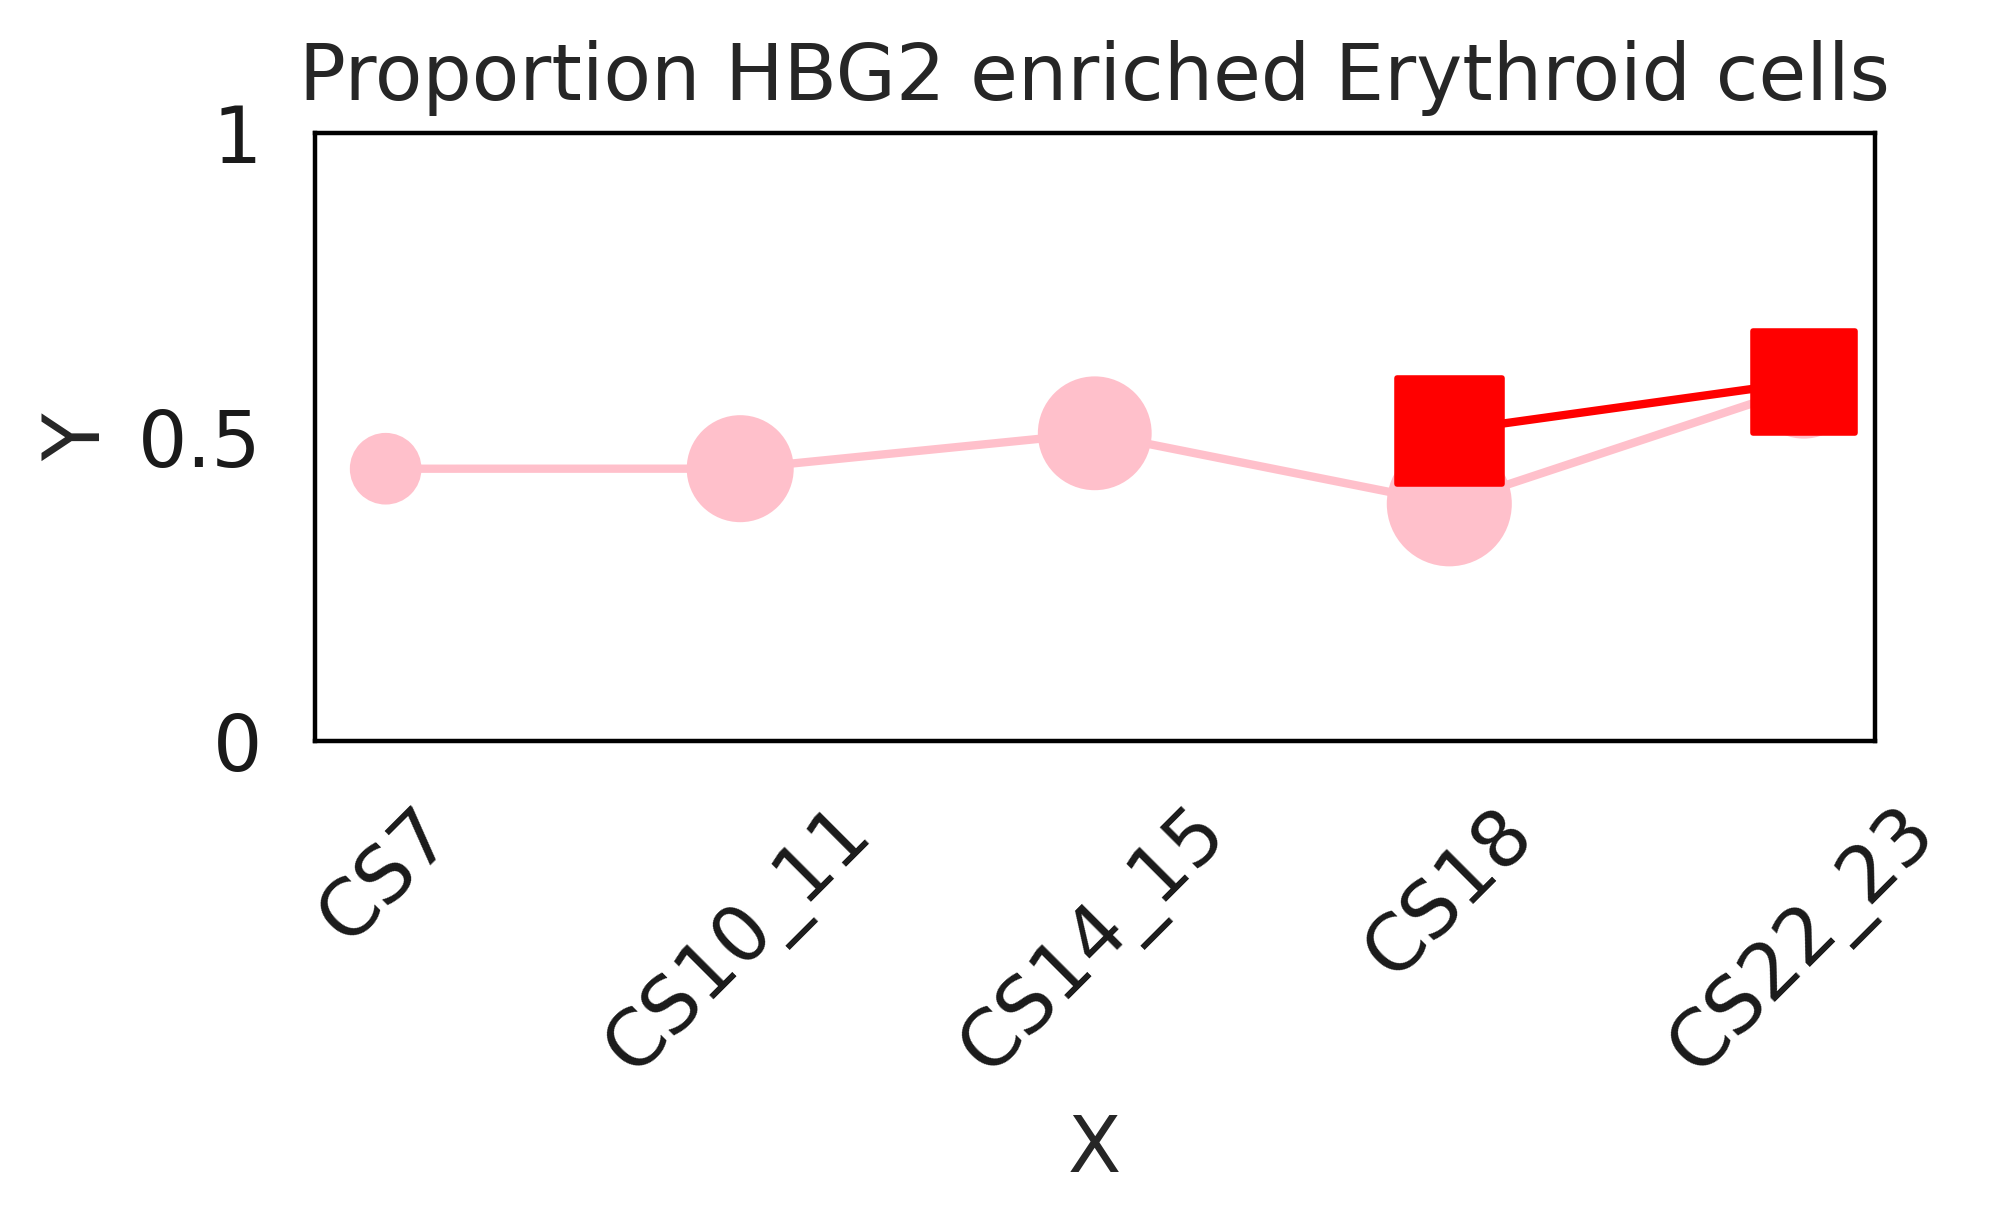

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


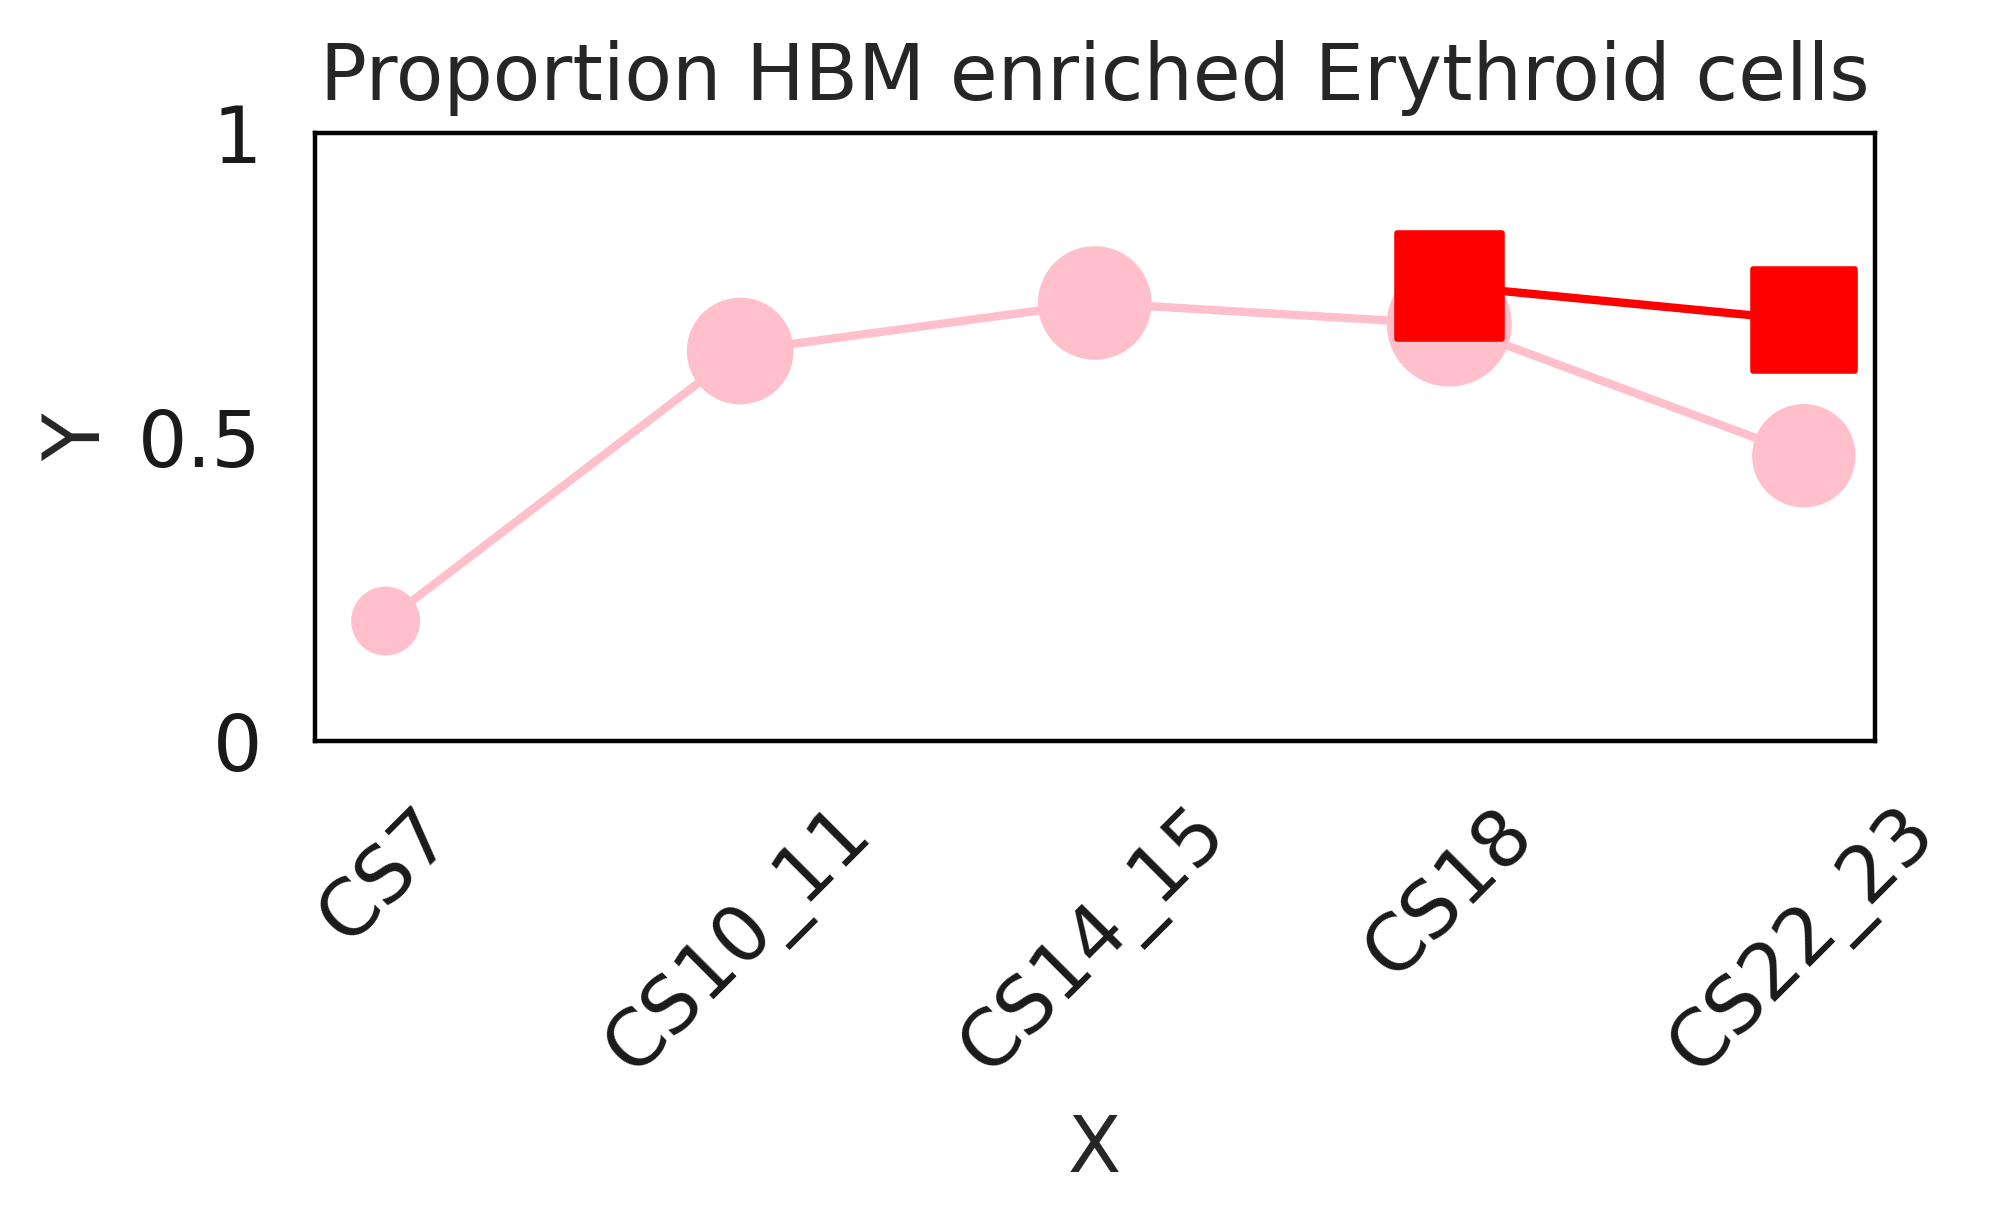

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:01)


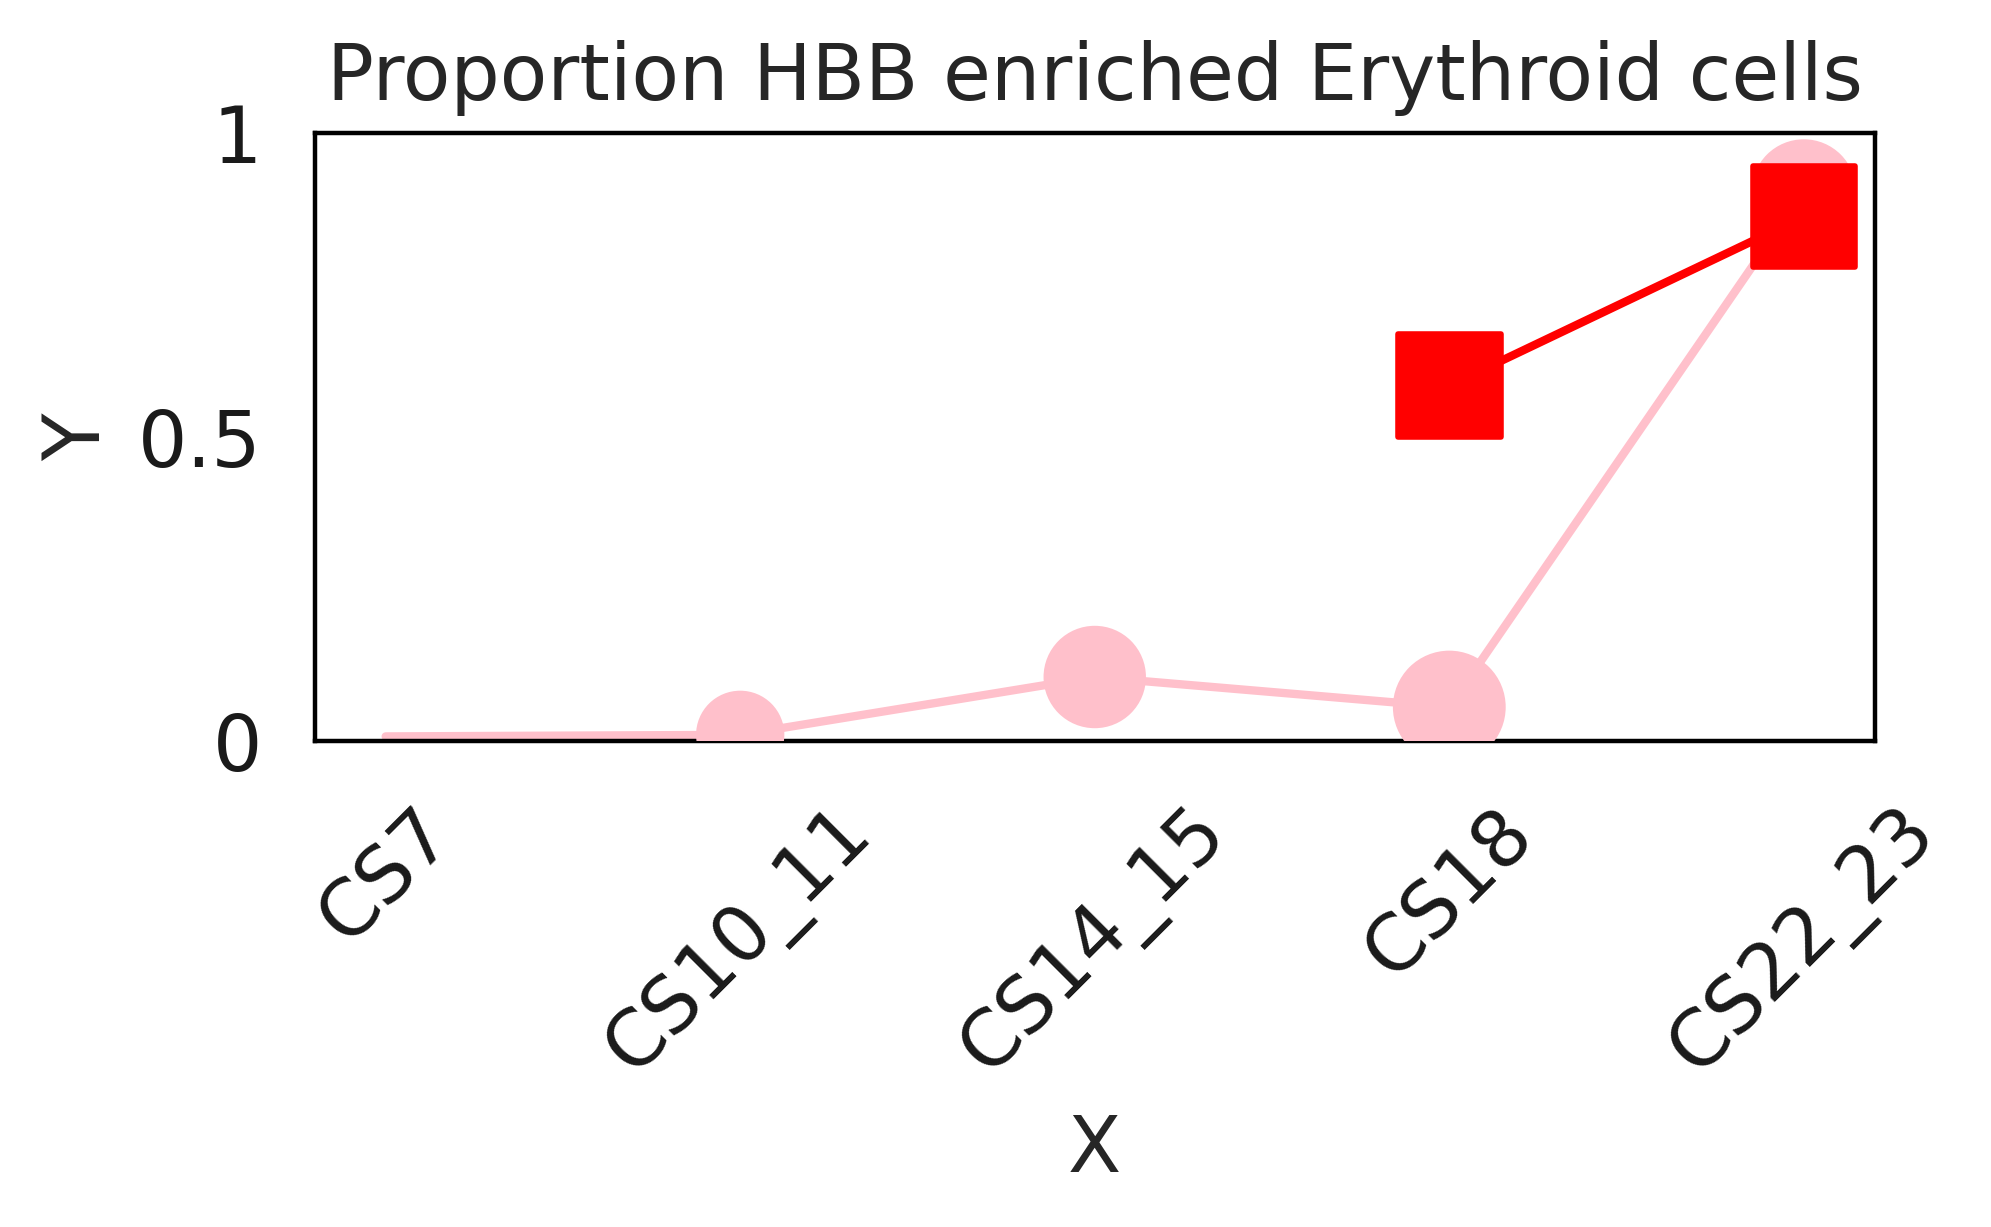

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


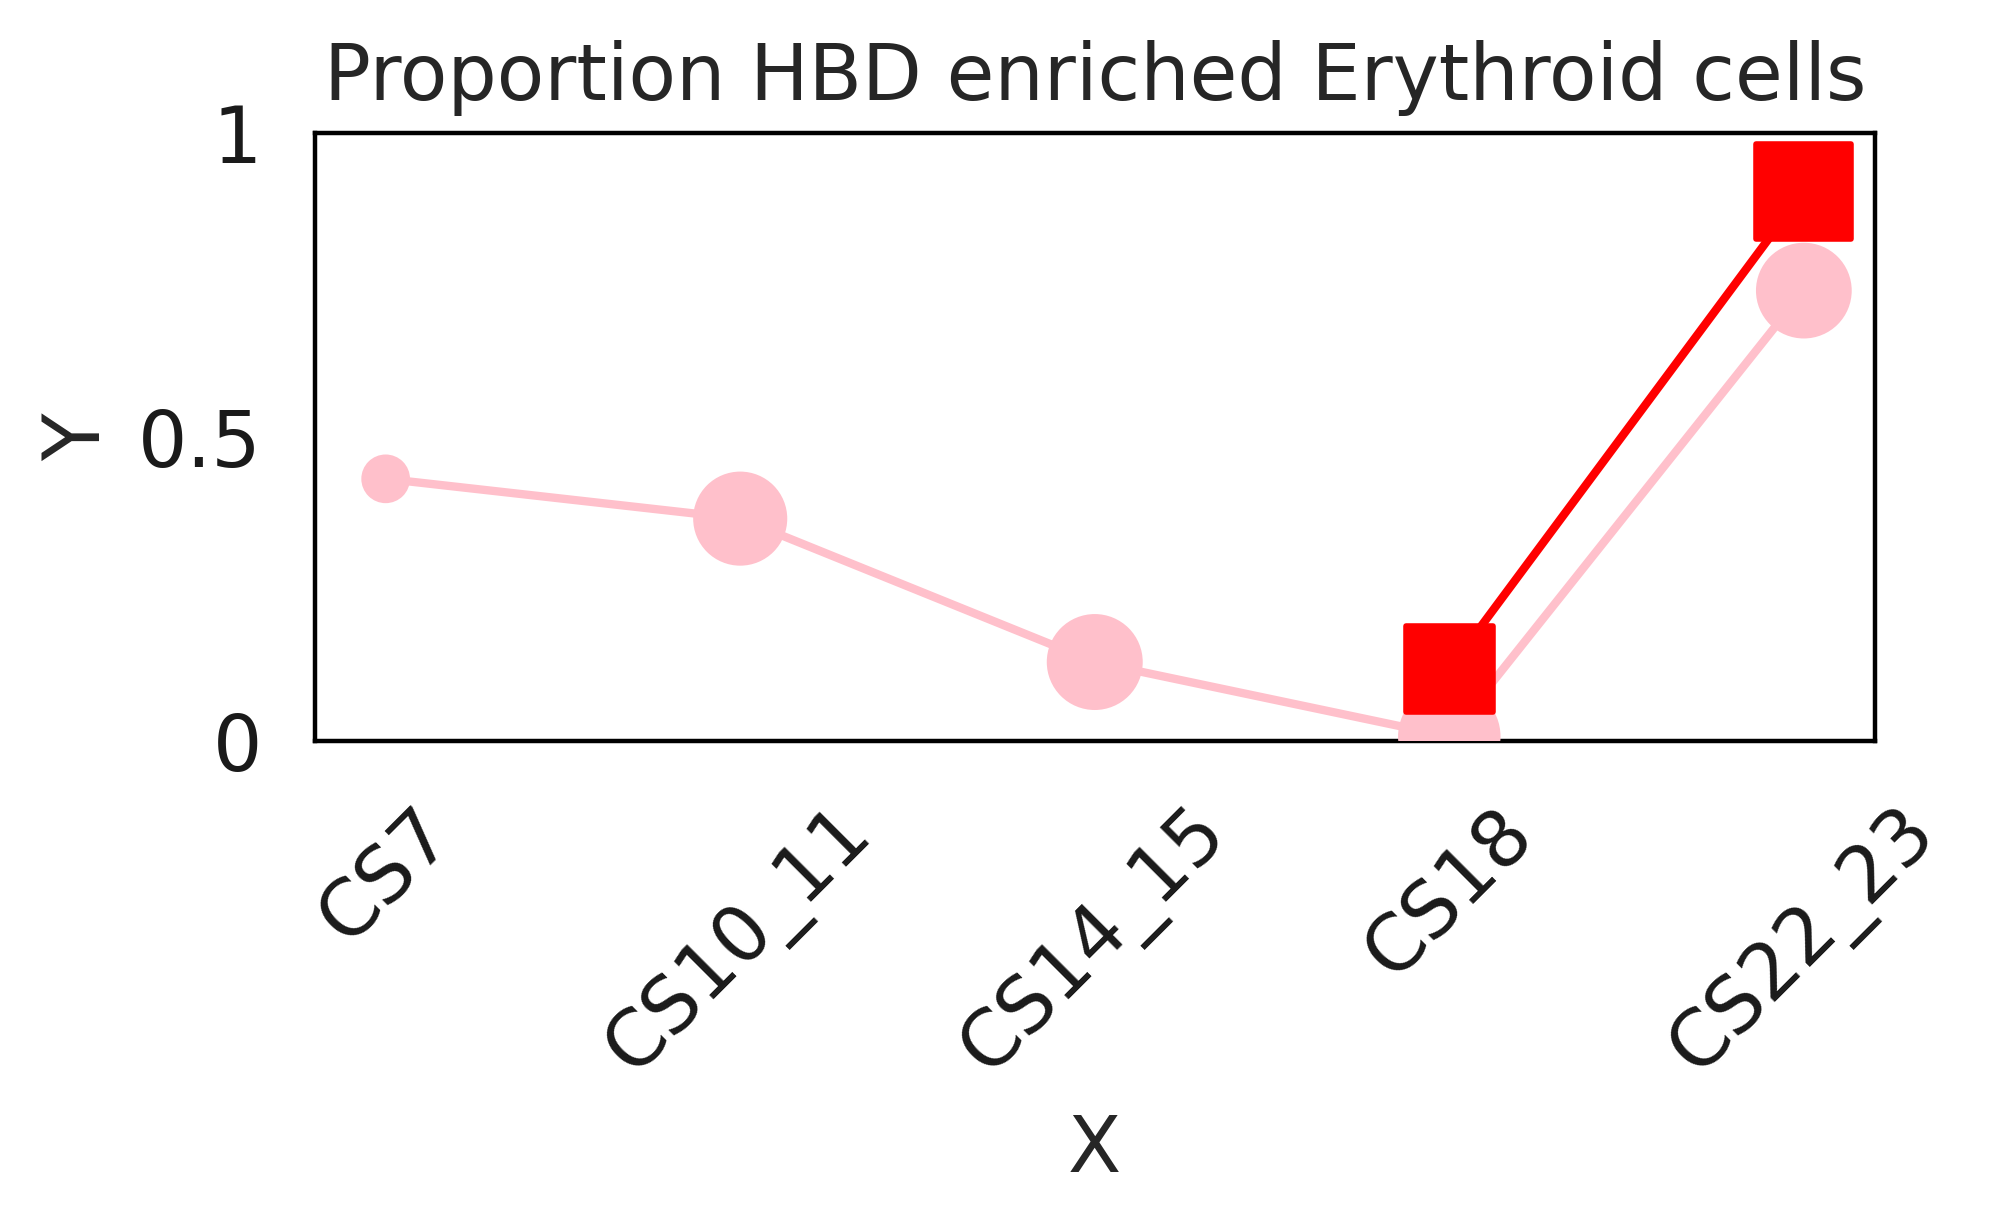

In [81]:
plt.rcParams['axes.grid'] = False
threshold_val = 0

concat_scores=pd.DataFrame()
for key in keys:
#    sc.tl.score_genes(adata, [key] , ctrl_size=50, gene_pool=None, n_bins=25, score_name=('key' + '_score'), random_state=0, copy=False, use_raw=None)
    sc.tl.score_genes(adata, keys[key] , ctrl_size=100, gene_pool=None, n_bins=50, score_name=('key' + '_score'), random_state=0, copy=False, use_raw=None)
#   adata.obs['key' + '_score'] = np.sum(adata[:, keys[key]].X,axis=1)#.todense()
    #adata.obs['key' + '_score'] = adata[:, [key]].X#.todense()
    adata.obs['stage_groups'] = adata.obs['corr_concat'][:]
    adata.obs['stage_groups'] = adata.obs['stage_groups'].astype(str)
    stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15']
    groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15']
    dic = dict(zip(stages,groups))
    #YS_HSC.obs['stage_groups'] = YS_HSC.obs['stage'].map(dic)
    adata.obs.loc[adata.obs['stage'].isin(stages),'stage_groups'] = adata.obs['stage'].map(dic)
    adata.obs['stage_groups'].unique()

    stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15','F61', 'F35', 'F32']

    groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15','liv_cs18','liv_cs22_23','liv_cs22_23']
    dic = dict(zip(stages,groups))
    adata.obs['stage_groups'] = adata.obs['stage'].map(dic)
    adata.obs['stage_groups'].unique()

    # order these categories by lineage time
    ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23', 'liv_cs18', 'liv_cs22_23']
    adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

    adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Erythroid_fliv','fliv')
    adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Embryonic_fliv','fliv')      
    adata.obs['stage_groups'].unique()

    # order these categories by lineage time
    ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23','liv_cs18','liv_cs22_23']
    adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

    scores = adata.obs[['key_score','stage_groups']]
    scores.columns = ['key_score','group']
    scores_median = scores.groupby('group').median()
    scores.groupby('group').median()
    scores = scores[scores['key_score']>threshold_val]
    #scores = scores[scores['key_score']>np.mean((scores['key_score']))]
    
    
    adata.obs['is_key'] = 'False'
    adata.obs.loc[adata.obs.index.isin(scores.index),'is_key'] = "True"
    norm_count = ((adata.obs.groupby(['stage_groups','is_key'], observed=True).count()).iloc[:,1]).reset_index()
    
    count1 = ((adata.obs.groupby(['stage_groups','is_key'], observed=False).count()).iloc[:,1]).reset_index()
    count1['stage'] = count1['stage'].astype(int)
    count1['stage'] = count1['stage'] + 1
    count2 = count1[:]

    for i in count1['stage_groups'].unique():
        for z in count1.index[count1['stage_groups'].isin([i])]:
            count2.loc[count2.index.isin([z]),'stage'] = (count1.loc[count1.index.isin([z]),'stage'] / sum(count1['stage'][count1['stage_groups'].isin([i])]))*100
    #count2.set_index(['leiden_mono', 'corr_concat'], inplace=True)
    
    count4 = count2[count2['is_key'].isin(["True"])]

    norm_count = ((adata.obs.groupby(['stage_groups','is_key']).count()).iloc[:,1]).reset_index()
    norm_count = norm_count[norm_count['is_key'].isin(['True'])]
    norm_count 
    
    y1 = list(count4['stage'][count4['stage_groups'].isin(['CS7','CS10_11', 'CS22_23', 'CS14_15', 'CS18'])])
    y2 =  list(count4['stage'][count4['stage_groups'].isin(['liv_cs18','liv_cs22_23'])])
    for length in range(0,(len(y1) - len(y2))):
        y2.insert(0,np.nan)
#     y1[y1==0 ] = np.nan
#     y2[y2==0 ] = np.nan
    
    # size counts
    size_counts = np.log10(scores.groupby('group').apply(len))
    y1_size = list(size_counts[size_counts.index.isin(['CS7','CS10_11', 'CS22_23', 'CS14_15', 'CS18'])]*100)
    y2_size = list(size_counts[size_counts.index.isin(['liv_cs18','liv_cs22_23'])]*100)
    y2_size =list(np.nan_to_num(y2_size, neginf=1))
    for length in range(0,(len(y1_size) - len(y2_size))):
        y2_size.insert(0,0)
    y2_size[y2_size==0 ] = np.nan
    
    y1 = [x / 100 for x in y1]
    y2 = [x / 100 for x in y2]
    
    import matplotlib.pyplot as plt 
    from matplotlib.pyplot import figure
    #figure(figsize=(5, 10), dpi=80)
    plt.rcParams.update({'font.size': 15})
    x=['CS7', 'CS10_11', 'CS14_15', 'CS18', 'CS22_23']
#     y1 = np.log10(y1)
#     y2 = np.log10(y2)
#     y1[y1==0 ] = np.nan
#     y2[y2==0 ] = np.nan
    
    fig = plt.figure(figsize=(5, 2), dpi=200)
    ax1 = fig.add_subplot()

    ax1.plot(x,y2,c='red',linestyle = None)
    ax1.plot(x,y1,c='pink',linestyle = None)
    ax1.scatter(x,y1,c='pink',s = y1_size ,marker='o', cmap='turbo',zorder=10  ) #y1*10
    ax1.scatter(x,y2,c='red',s = y2_size, marker='s', cmap='turbo',zorder=10 )# y1*10
    
    
    ymin = np.nanmin((list(y1) + list(y2)))- (np.nanmin((list(y1) + list(y2)))*0.1)
    ymax = np.nanmax((list(y1) + list(y2))) + (np.nanmax((list(y1) + list(y2)))*0.1)
    plt.grid(False)
    plt.xticks(rotation=45)
    positions = (ymin, ((ymax - ymin)/2)+ymin, ymax)
    labels = ("0", "0.5", "1")
    plt.yticks(positions, labels)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim(ymin, ymax)
    plt.title("Proportion " + key + " enriched Erythroid cells")
    plt.xticks(rotation=45)
    #plt.axhline(y=0, color='r', linestyle='-')


    # import matplotlib.lines as mlines
    # pinkcircle = mlines.Line2D([], [], color='pink', marker='o', linestyle='None',
    #                           markersize=10, label='YS')
    # redsquare = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
    #                           markersize=10, label='liv')
    # plt.legend(handles=[pinkcircle, redsquare])

    plt.savefig(("./figures/"+ key+ ".pdf"), dpi=300,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )
    plt.show()
    
    concat_tmp = pd.DataFrame((adata.obs.groupby(['stage_groups','is_key']).count()).iloc[:,1]).reset_index(1)
    concat_tmp.columns = [(key + '_enriched'),'counts']
#     trend = mk.original_test(y1)
#     p = trend.p
#     z = trend.z
#     concat_tmp['mannkendall_p'] = p
#     concat_tmp['mannkendall_z'] = z
    concat_scores = pd.concat([concat_tmp,concat_scores],axis=1)
concat_scores.to_csv('./HB_gene_scores.csv')

In [80]:
concat_scores

HBD_enriched  counts  mannkendall_p  mannkendall_z HBB_enriched  \
stage_groups                                                                   
CS7                 False      22       0.806496      -0.244949        False   
CS7                  True       4       0.806496      -0.244949         True   
CS10_11             False    1893       0.806496      -0.244949        False   
CS10_11              True     346       0.806496      -0.244949         True   
CS14_15             False    5972       0.806496      -0.244949        False   
CS14_15              True     444       0.806496      -0.244949         True   
CS18                False   43191       0.806496      -0.244949        False   
CS18                 True    1103       0.806496      -0.244949         True   
CS22_23             False    1055       0.806496      -0.244949        False   
CS22_23              True     432       0.806496      -0.244949         True   
liv_cs18            False    3816       0.806496      -0.244949        False   
liv_cs18             True     265       0.806496      -0.244949         True   
liv_cs22_23         False    1563       0.806496      -0.244949        False   
liv_cs22_23          True     841       0.806496      -0.244949         True   

              counts  mannkendall_p  mannkendall_z HBM_enriched  counts  ...  \
stage_groups                                                             ...   
CS7               25       0.086411       1.714643        False       6  ...   
CS7                1       0.086411       1.714643         True      20  ...   
CS10_11         2074       0.086411       1.714643        False     180  ...   
CS10_11          165       0.086411       1.714643         True    2059  ...   
CS14_15         5322       0.086411       1.714643        False     324  ...   
CS14_15         1094       0.086411       1.714643         True    6092  ...   
CS18           38960       0.086411       1.714643        False    2829  ...   
CS18            5334       0.086411       1.714643         True   41465  ...   
CS22_23           27       0.086411       1.714643        False     217  ...   
CS22_23         1460       0.086411       1.714643         True    1270  ...   
liv_cs18        1399       0.086411       1.714643        False     162  ...   
liv_cs18        2682       0.086411       1.714643         True    3919  ...   
liv_cs22_23      145       0.086411       1.714643        False     147  ...   
liv_cs22_23     2259       0.086411       1.714643         True    2257  ...   

              mannkendall_p  mannkendall_z HBE1_enriched  counts  \
stage_groups                                                       
CS7                0.086411       1.714643         False       1   
CS7                0.086411       1.714643          True      25   
CS10_11            0.086411       1.714643         False      71   
CS10_11            0.086411       1.714643          True    2168   
CS14_15            0.086411       1.714643         False      22   
CS14_15            0.086411       1.714643          True    6394   
CS18               0.086411       1.714643         False     258   
CS18               0.086411       1.714643          True   44036   
CS22_23            0.086411       1.714643         False     771   
CS22_23            0.086411       1.714643          True     716   
liv_cs18           0.086411       1.714643         False    1654   
liv_cs18           0.086411       1.714643          True    2427   
liv_cs22_23        0.086411       1.714643         False    2394   
liv_cs22_23        0.086411       1.714643          True      10   

              mannkendall_p  mannkendall_z HBZ_enriched  counts  \
stage_groups                                                      
CS7                     1.0              0        False       0   
CS7                     1.0              0         True      26   
CS10_11                 1.0              0        False      60   
CS10_11                 1.0

In [139]:
keys = { 'BCL11A':['BCL11A'],
 'ZBTB7A':['ZBTB7A'],}

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


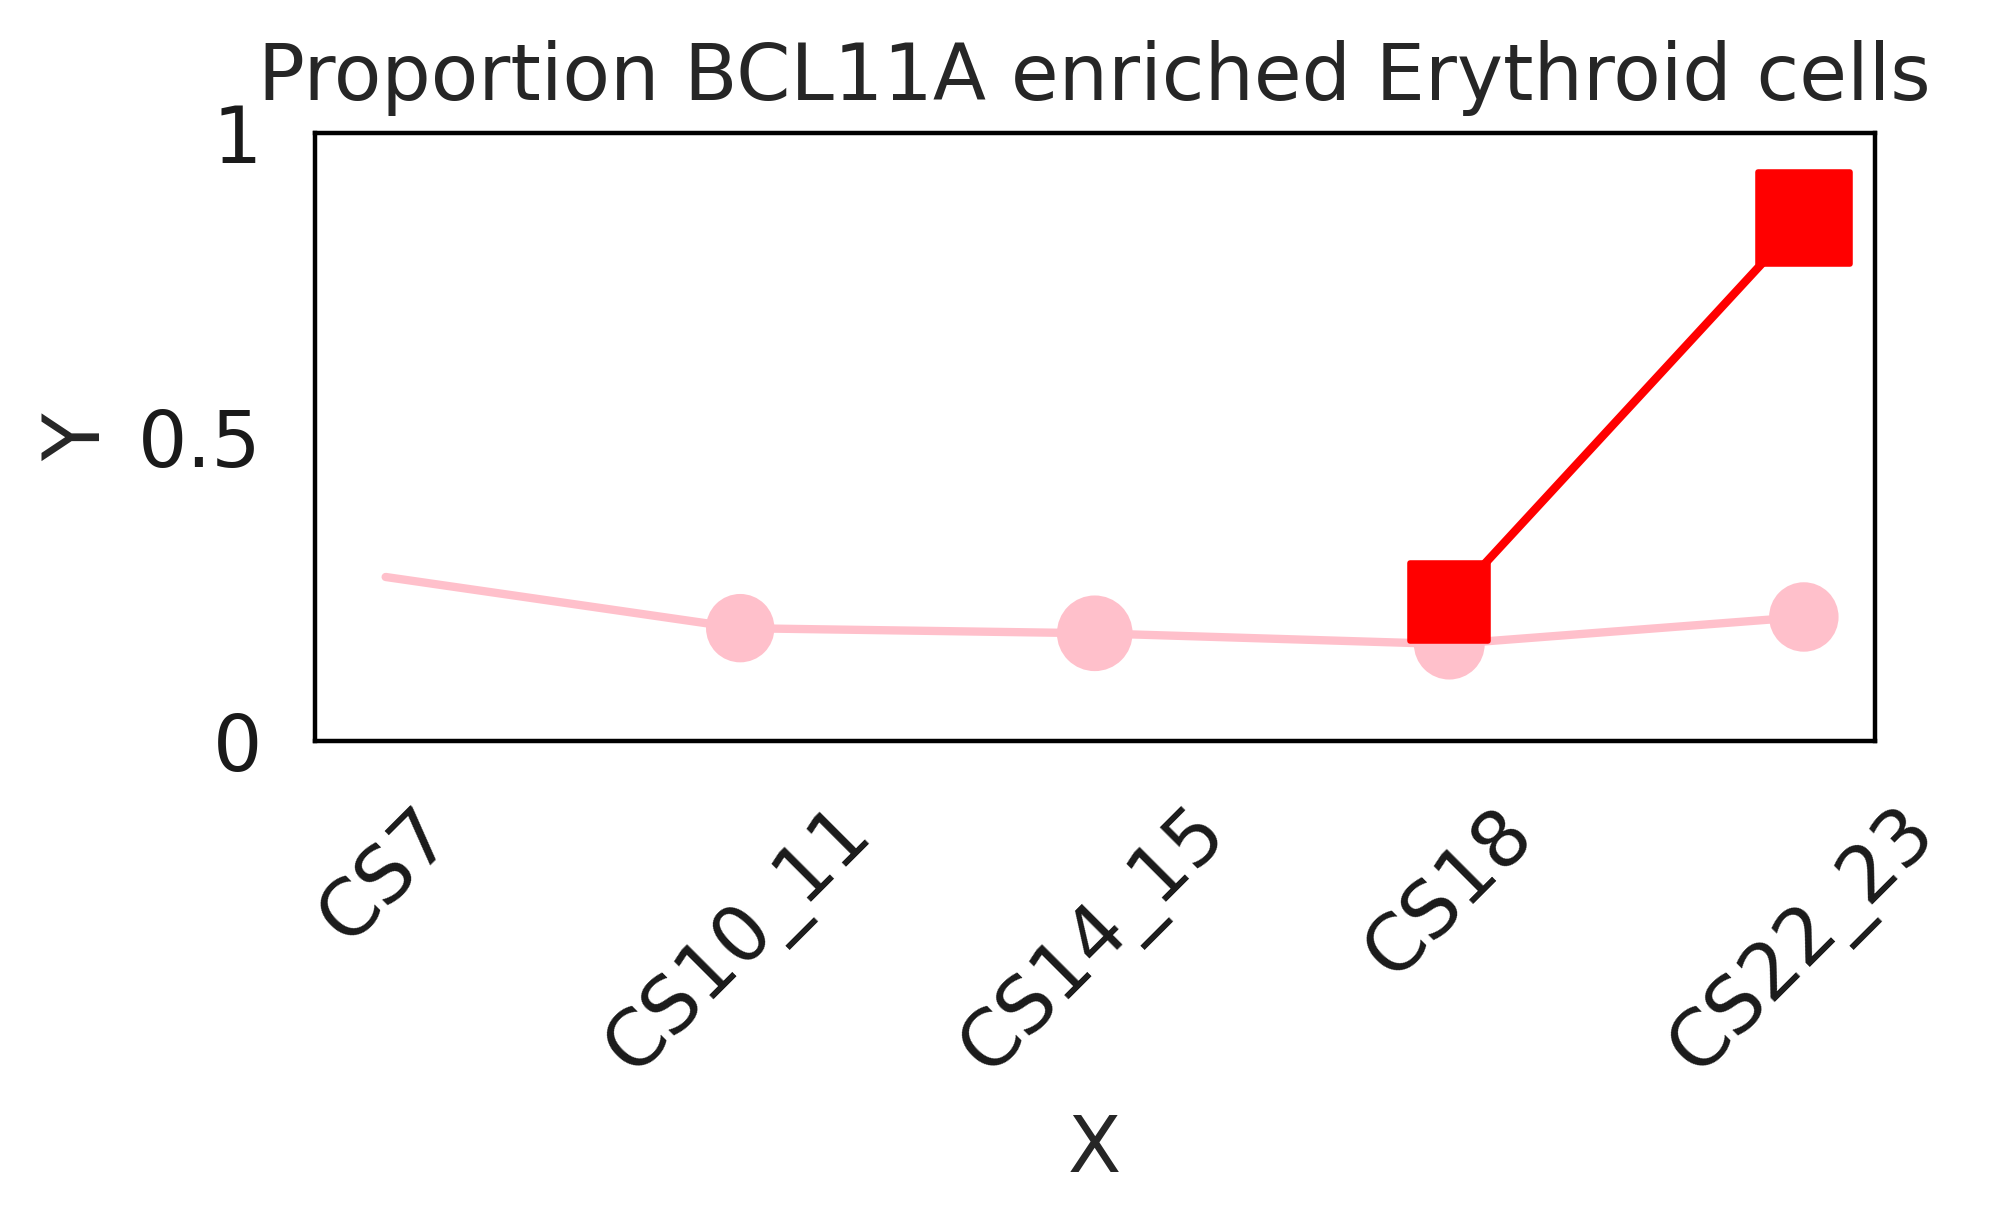

computing score 'key_score'
    finished: added
    'key_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


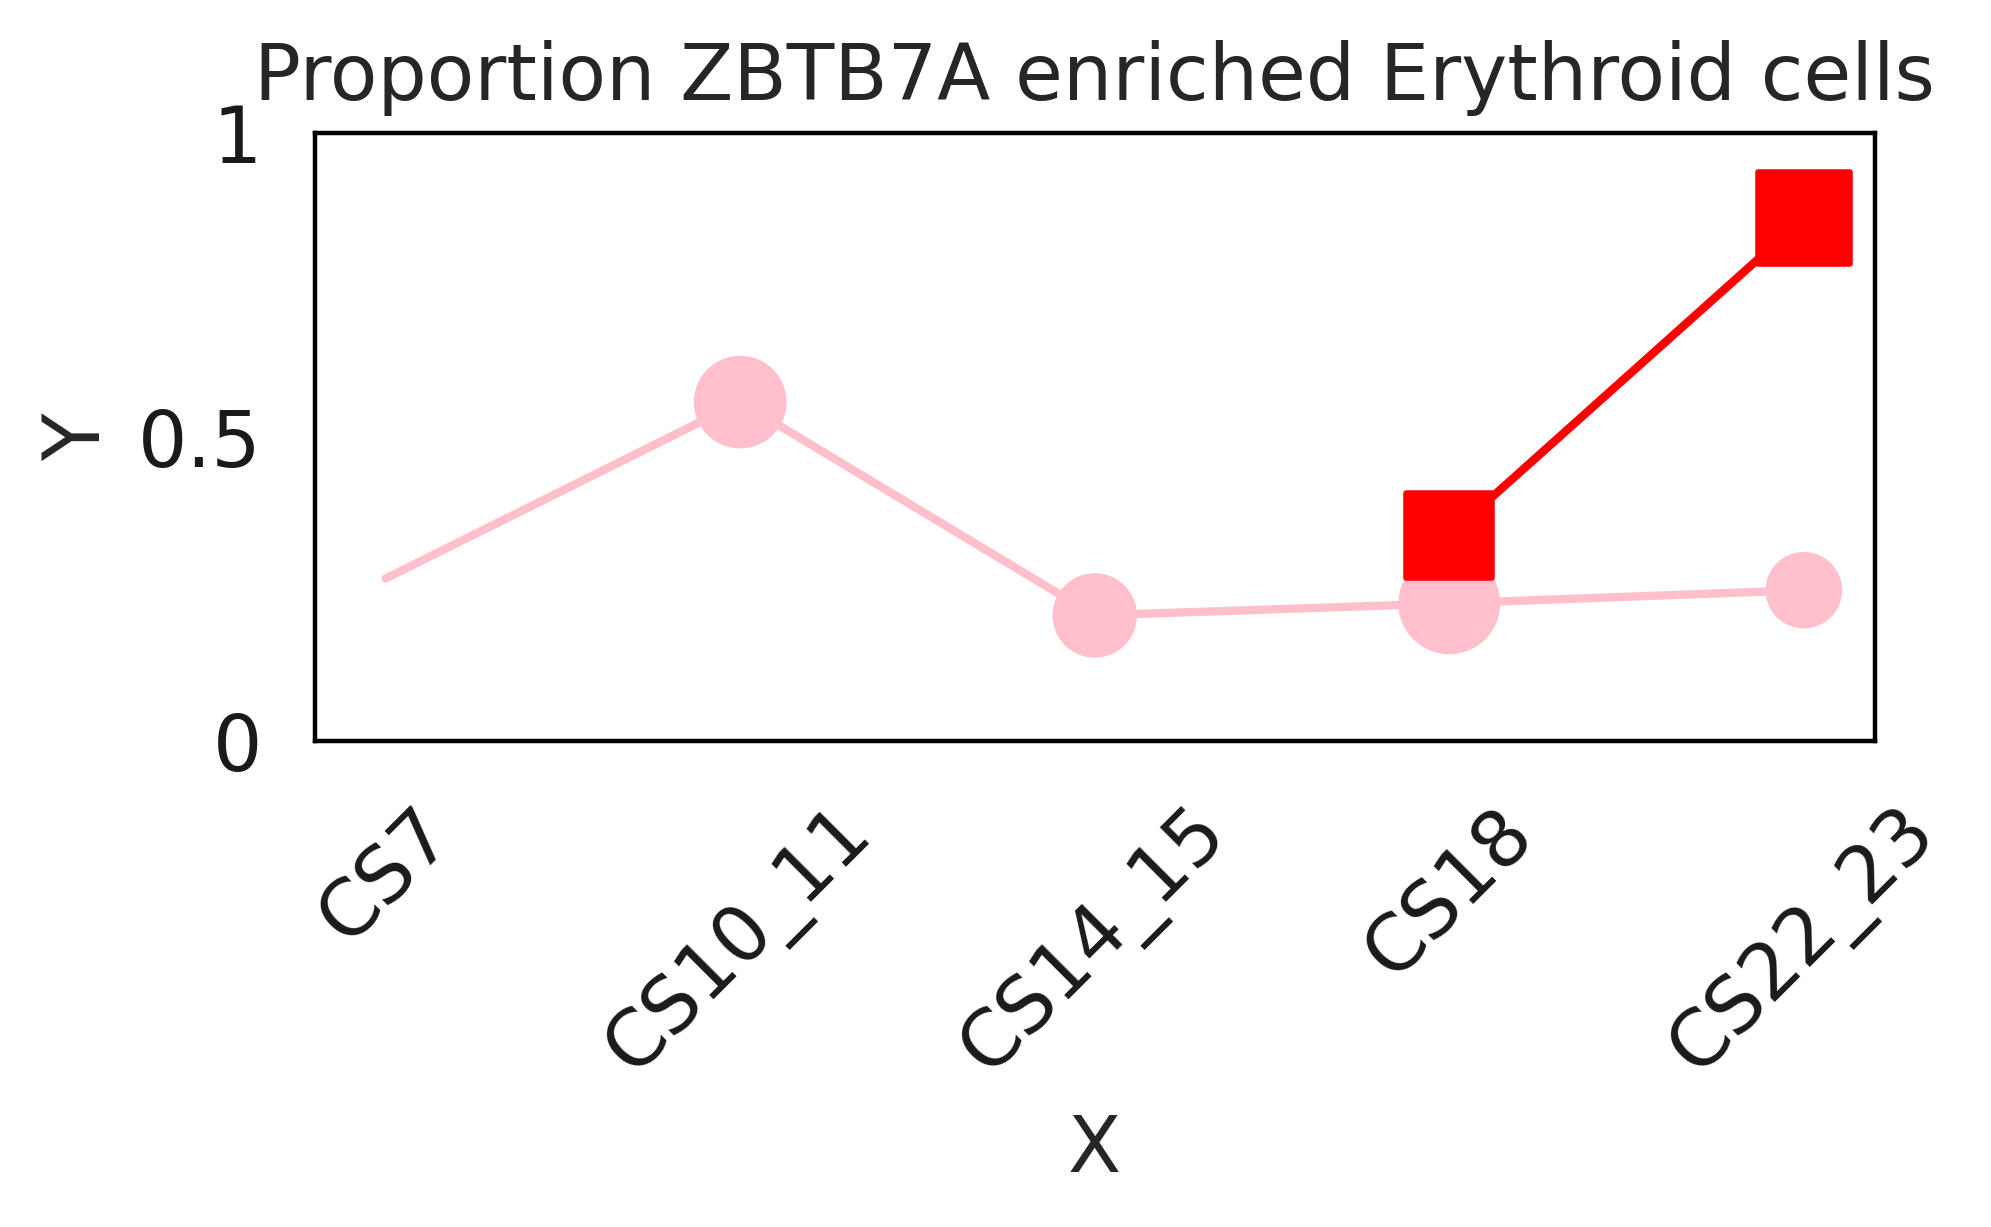

In [145]:
plt.rcParams['axes.grid'] = False
threshold_val = 0
for key in keys:
#    sc.tl.score_genes(adata, [key] , ctrl_size=50, gene_pool=None, n_bins=25, score_name=('key' + '_score'), random_state=0, copy=False, use_raw=None)
    sc.tl.score_genes(adata, keys[key] , ctrl_size=100, gene_pool=None, n_bins=50, score_name=('key' + '_score'), random_state=0, copy=False, use_raw=None)
#   adata.obs['key' + '_score'] = np.sum(adata[:, keys[key]].X,axis=1)#.todense()
    #adata.obs['key' + '_score'] = adata[:, [key]].X#.todense()
    adata.obs['stage_groups'] = adata.obs['corr_concat'][:]
    adata.obs['stage_groups'] = adata.obs['stage_groups'].astype(str)
    stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15']
    groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15']
    dic = dict(zip(stages,groups))
    #YS_HSC.obs['stage_groups'] = YS_HSC.obs['stage'].map(dic)
    adata.obs.loc[adata.obs['stage'].isin(stages),'stage_groups'] = adata.obs['stage'].map(dic)
    adata.obs['stage_groups'].unique()

    stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15','F61', 'F35', 'F32']

    groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15','liv_cs18','liv_cs22_23','liv_cs22_23']
    dic = dict(zip(stages,groups))
    adata.obs['stage_groups'] = adata.obs['stage'].map(dic)
    adata.obs['stage_groups'].unique()

    # order these categories by lineage time
    ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23', 'liv_cs18', 'liv_cs22_23']
    adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

    adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Erythroid_fliv','fliv')
    adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Embryonic_fliv','fliv')      
    adata.obs['stage_groups'].unique()

    # order these categories by lineage time
    ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23','liv_cs18','liv_cs22_23']
    adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

    scores = adata.obs[['key_score','stage_groups']]
    scores.columns = ['key_score','group']
    scores_median = scores.groupby('group').median()
    scores.groupby('group').median()
    scores = scores[scores['key_score']>threshold_val]
    #scores = scores[scores['key_score']>np.mean((scores['key_score']))]
    
    
    adata.obs['is_key'] = 'False'
    adata.obs.loc[adata.obs.index.isin(scores.index),'is_key'] = "True"
    norm_count = ((adata.obs.groupby(['stage_groups','is_key'], observed=True).count()).iloc[:,1]).reset_index()
    
    count1 = ((adata.obs.groupby(['stage_groups','is_key'], observed=False).count()).iloc[:,1]).reset_index()
    count1['stage'] = count1['stage'].astype(int)
    count1['stage'] = count1['stage'] + 1
    count2 = count1[:]

    for i in count1['stage_groups'].unique():
        for z in count1.index[count1['stage_groups'].isin([i])]:
            count2.loc[count2.index.isin([z]),'stage'] = (count1.loc[count1.index.isin([z]),'stage'] / sum(count1['stage'][count1['stage_groups'].isin([i])]))*100
    #count2.set_index(['leiden_mono', 'corr_concat'], inplace=True)
    
    count4 = count2[count2['is_key'].isin(["True"])]

    norm_count = ((adata.obs.groupby(['stage_groups','is_key']).count()).iloc[:,1]).reset_index()
    norm_count = norm_count[norm_count['is_key'].isin(['True'])]
    norm_count 
    
    y1 = list(count4['stage'][count4['stage_groups'].isin(['CS7','CS10_11', 'CS22_23', 'CS14_15', 'CS18'])])
    y2 =  list(count4['stage'][count4['stage_groups'].isin(['liv_cs18','liv_cs22_23'])])
    for length in range(0,(len(y1) - len(y2))):
        y2.insert(0,np.nan)
#     y1[y1==0 ] = np.nan
#     y2[y2==0 ] = np.nan
    
    # size counts
    size_counts = np.log10(scores.groupby('group').apply(len))
    y1_size = list(size_counts[size_counts.index.isin(['CS7','CS10_11', 'CS22_23', 'CS14_15', 'CS18'])]*100)
    y2_size = list(size_counts[size_counts.index.isin(['liv_cs18','liv_cs22_23'])]*100)
    y2_size =list(np.nan_to_num(y2_size, neginf=1))
    for length in range(0,(len(y1_size) - len(y2_size))):
        y2_size.insert(0,0)
    y2_size[y2_size==0 ] = np.nan
    
    y1 = [x / 100 for x in y1]
    y2 = [x / 100 for x in y2]
    
    import matplotlib.pyplot as plt 
    from matplotlib.pyplot import figure
    #figure(figsize=(5, 10), dpi=80)
    plt.rcParams.update({'font.size': 15})
    x=['CS7', 'CS10_11', 'CS14_15', 'CS18', 'CS22_23']
#     y1 = np.log10(y1)
#     y2 = np.log10(y2)
#     y1[y1==0 ] = np.nan
#     y2[y2==0 ] = np.nan
    
    fig = plt.figure(figsize=(5, 2), dpi=200)
    ax1 = fig.add_subplot()

    ax1.plot(x,y2,c='red',linestyle = None)
    ax1.plot(x,y1,c='pink',linestyle = None)
    ax1.scatter(x,y1,c='pink',s = y1_size ,marker='o', cmap='turbo',zorder=10  ) #y1*10
    ax1.scatter(x,y2,c='red',s = y2_size, marker='s', cmap='turbo',zorder=10 )# y1*10
    
    
    ymin = -0.05#np.nanmin((list(y1) + list(y2)))- (np.nanmin((list(y1) + list(y2)))*0.3)
    ymax = np.nanmax((list(y1) + list(y2))) + (np.nanmax((list(y1) + list(y2)))*0.2)
    plt.grid(False)
    plt.xticks(rotation=45)
    positions = (ymin, ((ymax - ymin)/2)+ymin, ymax)
    labels = ("0", "0.5", "1")
    plt.yticks(positions, labels)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim(ymin, ymax)
    plt.title("Proportion " + key + " enriched Erythroid cells")
    plt.xticks(rotation=45)
    #plt.axhline(y=0, color='r', linestyle='-')


    # import matplotlib.lines as mlines
    # pinkcircle = mlines.Line2D([], [], color='pink', marker='o', linestyle='None',
    #                           markersize=10, label='YS')
    # redsquare = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
    #                           markersize=10, label='liv')
    # plt.legend(handles=[pinkcircle, redsquare])

    plt.savefig(("./figures/"+ key+ ".pdf"), dpi=300,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )
    plt.show()

# Track plots

In [89]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, color_map='viridis')
plt.rcParams['figure.figsize'] = [15, 15]

In [90]:
run_name = 'YS_fliv_ery_HB'
save_loc = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad'
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV"

# Required: Name of first object
data2 = "_ys"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Required: Name of second object
data1 = "_fliv"
# Provide categorical to join between datasets
cat1 = "cell.labels"

In [91]:
import os
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
adata = sc.read(Object)
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'tissue_fetal_id'],
      dtype='object')

In [92]:
obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/Combined_YS_Fliver_meta_20210929.csv',index_col=0)
adata.obs = obs

In [93]:
common_cat = "corr_concat" 
adata.obs[common_cat] = "corr_concat"
adata.obs.loc[adata.obs['tissue'].isin(['YS']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['YS']),cat1].astype(str) + data2
adata.obs.loc[adata.obs['tissue'].isin(['Liver']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['Liver']),cat2].astype(str) + data1

In [94]:
adata.obs["lr_batch"]  = adata.obs["tissue"].astype(str) + '_' +  adata.obs['fetal.ids'].astype(str)

In [95]:
np.min(adata.X)

0.0

In [96]:
# adata_concat = adata[adata.obs['tissue']==0]
# for i in adata.obs['tissue'].unique():
#     tmp = adata[adata.obs['tissue'].isin([i])]
#     sc.pp.scale(tmp, max_value=10,zero_center=True)
#     adata_concat = adata_concat.concatenate(tmp, join='inner')
# adata = adata_concat[:]

In [56]:
adata_ys = adata[adata.obs['tissue'].isin(['YS'])]
sc.pp.scale(adata_ys, max_value=10,zero_center=True)
adata_Liver = adata[adata.obs['tissue'].isin(['Liver'])]
sc.pp.scale(adata_Liver, max_value=10,zero_center=True)

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [57]:
# adata = sc.read('./adata_ys_liv_scaled.h5ad')

In [97]:
adata2 = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/gastrulation_data_human_210521/human_gastrulation_lr_predicted_corr_concat_raw_counts_180122.h5ad')

In [98]:
adata2.obs['corr_concat'].unique()

['MK_lineage_Yolk Sac_gastrulation', 'HSPC_lineage_Yolk Sac_gastrulation', 'Erythroid_Yolk Sac_gastrulation', 'Macrophage_lineage_Yolk Sac_gastrulation', 'Early_Erythroid_Yolk Sac_gastrulation']
Categories (5, object): ['Early_Erythroid_Yolk Sac_gastrulation', 'Erythroid_Yolk Sac_gastrulation', 'HSPC_lineage_Yolk Sac_gastrulation', 'MK_lineage_Yolk Sac_gastrulation', 'Macrophage_lineage_Yolk Sac_gastrulation']

In [99]:
#adata2 = adata2[adata2.obs['corr_concat'].isin(['Early_Erythroid_Yolk Sac_gastrulation', 'Erythroid_Yolk Sac_gastrulation', 'HSPC_lineage_Yolk Sac_gastrulation'])]

In [100]:
adata2.obs['stage'] = 'CS7'
adata2.obs["lr_batch"] = 'YS_gastrula_CS7'
adata2.obs["tissue"] = 'gastrula' 
adata2.obs['lr_batch'] = 'Gastrula_CS7'

In [62]:
sc.pp.scale(adata2, max_value=10,zero_center=True)

In [63]:
adata = adata_ys.concatenate([adata2,adata_Liver],join='inner')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/merge.py:895: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [101]:
#adata = adata.concatenate(adata2,join='inner')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/merge.py:895: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [65]:
# adata.write('adata_ys_gas_liv_scaled.h5ad')

In [66]:
np.max(adata.X)

10.0

In [102]:
adata.obs['dataset_annot'] = adata.obs['cell.labels'][:]

In [103]:
adata.obs['stage_groups'] = adata.obs['cell.labels'][:]
adata.obs['stage_groups'] = adata.obs['stage'].astype(str)
stages= ['CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15']
groups = ['CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15']
dic = dict(zip(stages,groups))
#YS_HSC.obs['stage_groups'] = YS_HSC.obs['stage'].map(dic)
adata.obs.loc[adata.obs['stage'].isin(stages),'stage_groups'] = adata.obs['stage'].map(dic)
adata.obs['stage_groups'].unique()
# order these categories by lineage time
adata.obs['stage_groups'] = adata.obs['stage_groups'].str.replace('Gastrula_HSPC_lineage_Yolk Sac_gastrulation','CS7')

ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23']
adata.obs['stage_groups'] = pd.Categorical(adata.obs['stage_groups'], categories=ordering) 

In [104]:
# remove = adata[adata.obs['stage_groups'].isin(['CS18'])][adata[adata.obs['stage_groups'].isin(['CS18'])][: , 'BCL11A'].X > 3, :].obs.index
# remove = remove.append(adata[adata.obs['stage_groups'].isin(['CS22_23'])][adata[adata.obs['stage_groups'].isin(['CS22_23'])][: , 'BCL11A'].X < 1, :].obs.index)
# adata = adata[~adata.obs.index.isin(remove)]

In [105]:
# sample_n = 1000
# sample_ids = adata.obs.groupby(['stage_groups']).apply(len)[adata.obs.groupby(['stage_groups']).apply(len)>sample_n].index
# keep = adata.obs.groupby(['stage_groups']).apply(len)[adata.obs.groupby(['stage_groups']).apply(len)<sample_n].index
# keep = list(adata.obs[adata.obs['stage_groups'].isin(keep)].index)+(list(adata.obs.loc[adata.obs['stage_groups'].isin(sample_ids)].groupby(['stage_groups']).sample(n = 1000,replace=False).index))
# adata = adata[adata.obs.index.isin(keep)]

In [106]:
# adata_subsamp = adata[adata.obs.index.isin(adata.obs.groupby(['stage_groups']).head(1000).index)]
#adata_subsamp = adata[adata.obs.groupby("stage_groups", group_keys=False).apply(pd.DataFrame.sample, n=1000,replace=True).index]
# index_keys = adata.obs.groupby("stage_groups", group_keys=False).apply(pd.DataFrame.sample, n=1000,replace=True).index
# adata_subsamp = adata[adata.obs.index.isin(index_keys)]

In [142]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig2_Haem/Erytrhroid_HB_percentage/YS_fliv_ery_HB.h5ad')

In [136]:
sc.pp.scale(adata, max_value=10,zero_center=True)

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [137]:
stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15','F61', 'F35', 'F32']
groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15','liv_cs18','liv_cs22_23','liv_cs22_23']
dic = dict(zip(stages,groups))
adata.obs['stage_groups'] = adata.obs['stage'].map(dic)
adata.obs['stage_groups'].unique()


# adata_concat = adata[adata.obs['tissue']==0]
# for i in adata.obs['tissue'].unique():
#     tmp = adata[adata.obs['tissue'].isin([i])]
#     sc.pp.scale(tmp, max_value=10,zero_center=True)
#     adata_concat = adata_concat.concatenate(tmp, join='inner')
# adata = adata_concat[:]

# adata_concat = adata[adata.obs['lr_batch']==0]
# for i in adata.obs['lr_batch'].unique():
#     tmp = adata[adata.obs['lr_batch'].isin([i])]
#     sc.pp.scale(tmp, max_value=100,zero_center=True)
#     adata_concat = adata_concat.concatenate(tmp, join='inner')
# adata = adata_concat[:]

for key in markers:
    sc.tl.score_genes(adata, markers[key] , ctrl_size=100, gene_pool=None, n_bins=20, score_name=(key + '_score'), random_state=0, copy=False, use_raw=None)

keep = [
 'Erythroid_ys',
 'Erythroid_fliv',
# 'Embryonic_Erythroid_fliv',
 'Erythroid_Yolk Sac_gastrulation',]
adata = adata[adata.obs[common_cat].isin(keep)]

sample_n = 100
sample_ids = adata.obs.groupby(['stage_groups']).apply(len)[adata.obs.groupby(['stage_groups']).apply(len)>sample_n].index
keep = adata.obs.groupby(['stage_groups']).apply(len)[adata.obs.groupby(['stage_groups']).apply(len)<sample_n].index
keep = list(adata.obs[adata.obs['stage_groups'].isin(keep)].index)+(list(adata.obs.loc[adata.obs['stage_groups'].isin(sample_ids)].groupby(['stage_groups']).sample(n = sample_n,replace=False).index))
# adata_subsamp = adata[adata.obs.index.isin(adata.obs.groupby(['stage_groups']).sample(n = 1000,replace=True)
adata_subsamp = adata[adata.obs.index.isin(keep)]

markers = { 'HBZ':['HBZ'],
 'HBE1':['HBE1'],
 'HBA1':['HBA1'],
 'HBA2':['HBA2'],
 'HBQ1':[ 'HBQ1'], 
 'HBG1':['HBG1'],
 'HBG2':['HBG2'],
 'HBM':['HBM'],
 'HBB':['HBB'],
 'HBD':['HBD'],
'BCL11A':['BCL11A'],
 'ZBTB7A':['ZBTB7A']
       }

computing score 'HBZ_score'
    finished: added
    'HBZ_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:04)
computing score 'HBE1_score'
    finished: added
    'HBE1_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:04)
computing score 'HBA1_score'
    finished: added
    'HBA1_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:04)
computing score 'HBA2_score'
    finished: added
    'HBA2_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:04)
computing score 'HBQ1_score'
    finished: added
    'HBQ1_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:04)
computing score 'HBG1_score'
    finished: added
    'HBG1_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:04)
computing score 'HBG2_score'
    finished: added
    'HBG2_score', score of gene set (adata.obs).
    100 total control genes a

In [129]:
# adata_concat = adata_subsamp[adata_subsamp.obs['stage_groups']==0]
# for i in adata_subsamp.obs['stage_groups'].unique():
#     tmp = adata_subsamp[adata_subsamp.obs['stage_groups'].isin([i])]
#     sc.pp.scale(tmp, max_value=10,zero_center=True)
#     adata_concat = adata_concat.concatenate(tmp, join='inner')
# adata_subsamp = adata_concat[:]

In [130]:
# sc.pp.scale(adata_subsamp, max_value=10,zero_center=True)
# adata_subsamp.X[adata_subsamp.X < 0] = 0

In [131]:
# perhaps nan the other groups when trying to plot? Also possible to plot enrichment rather than expression

In [132]:
# for key in markers:
#     sc.tl.score_genes(adata_subsamp, markers[key] , ctrl_size=100, gene_pool=None, n_bins=50, score_name=(key + '_score'), random_state=0, copy=False, use_raw=None)

In [138]:
adata_subsamp = sc.AnnData(X = adata_subsamp.obs[adata_subsamp.obs.columns[adata_subsamp.obs.columns.str.contains('_score')]],obs= adata_subsamp.obs)

In [139]:
adata_subsamp.var.index = adata_subsamp.var.index.str.replace('_score','')

Trying to set attribute `.obs` of view, copying.


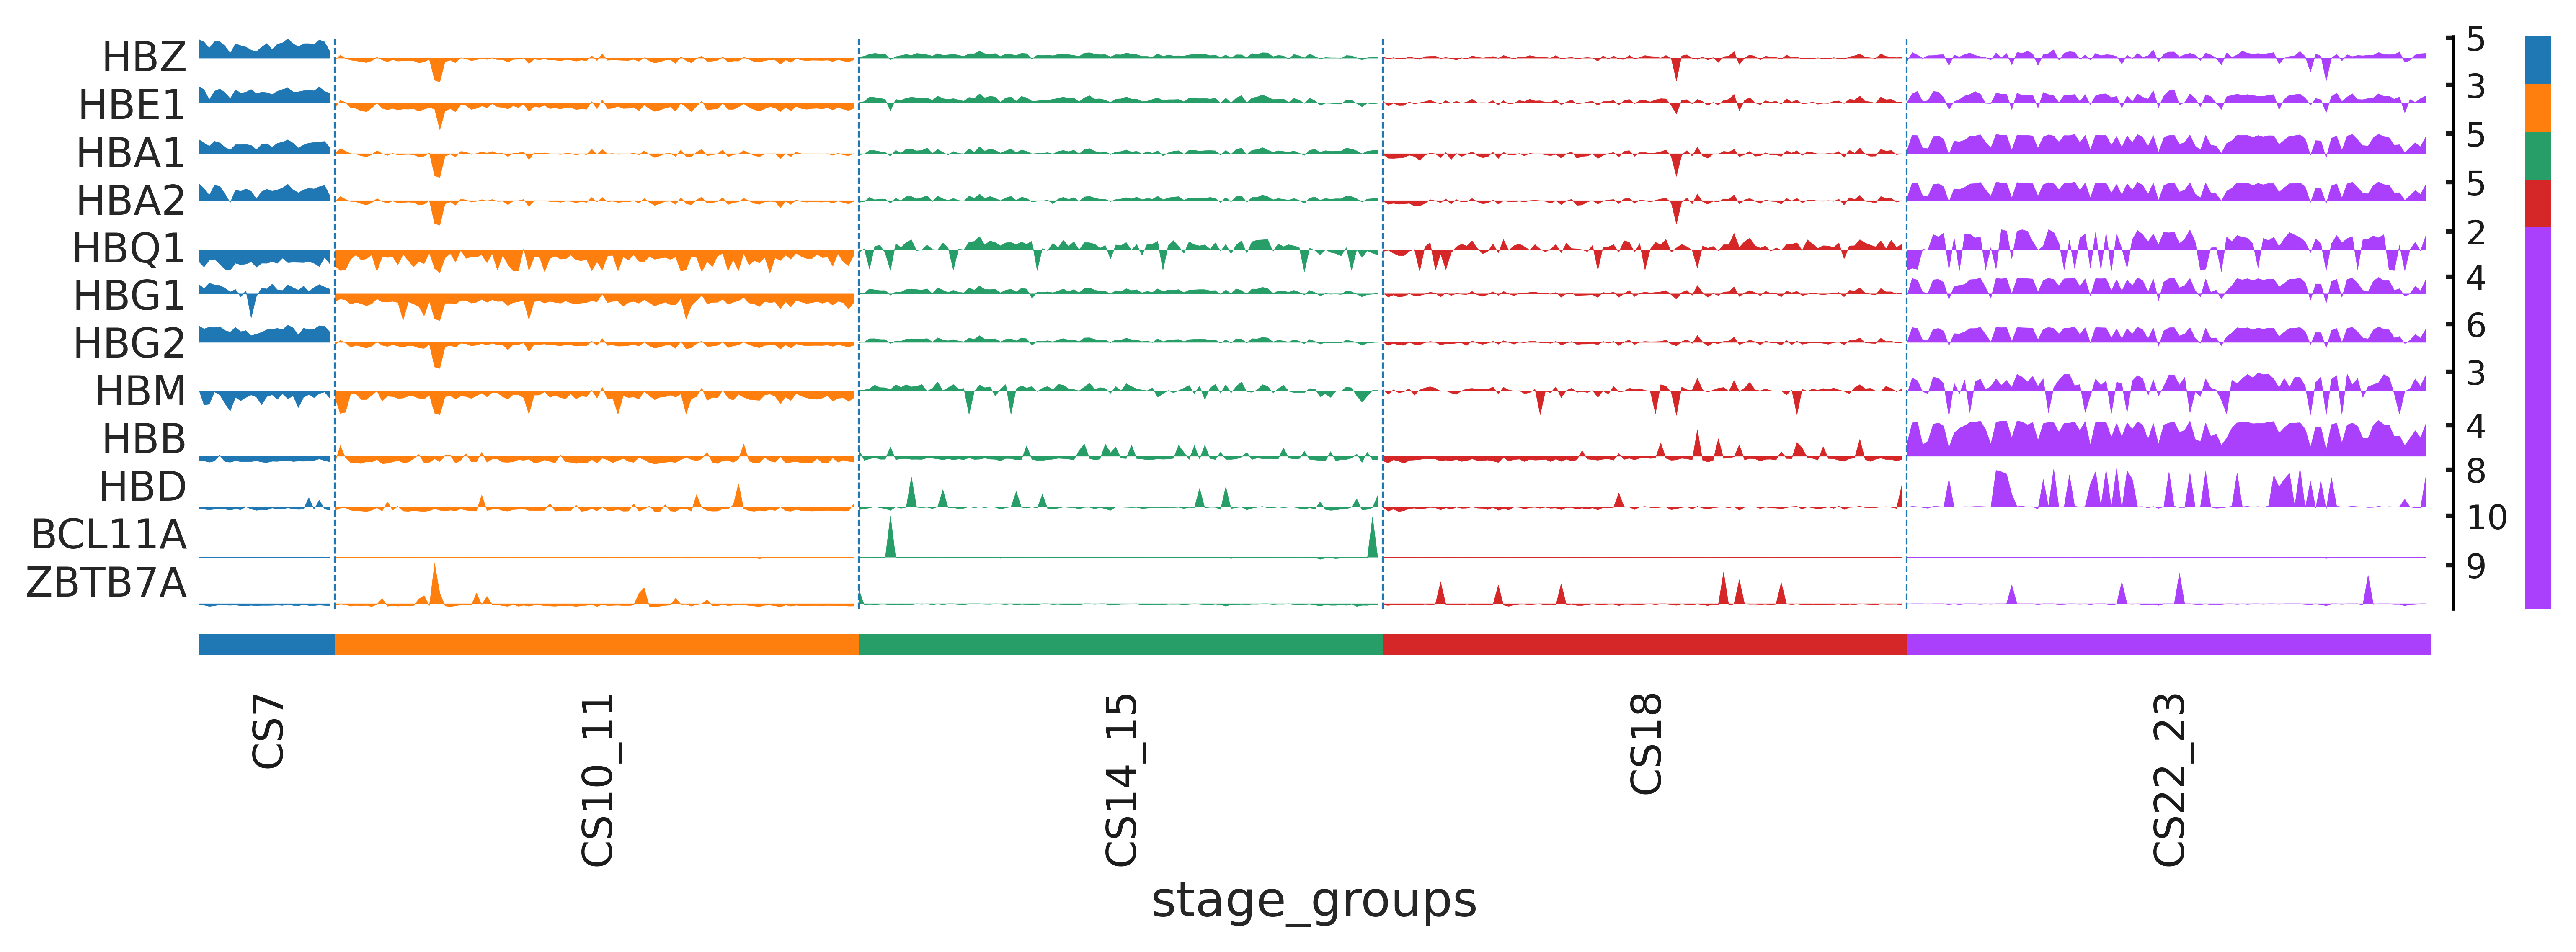

Trying to set attribute `.obs` of view, copying.


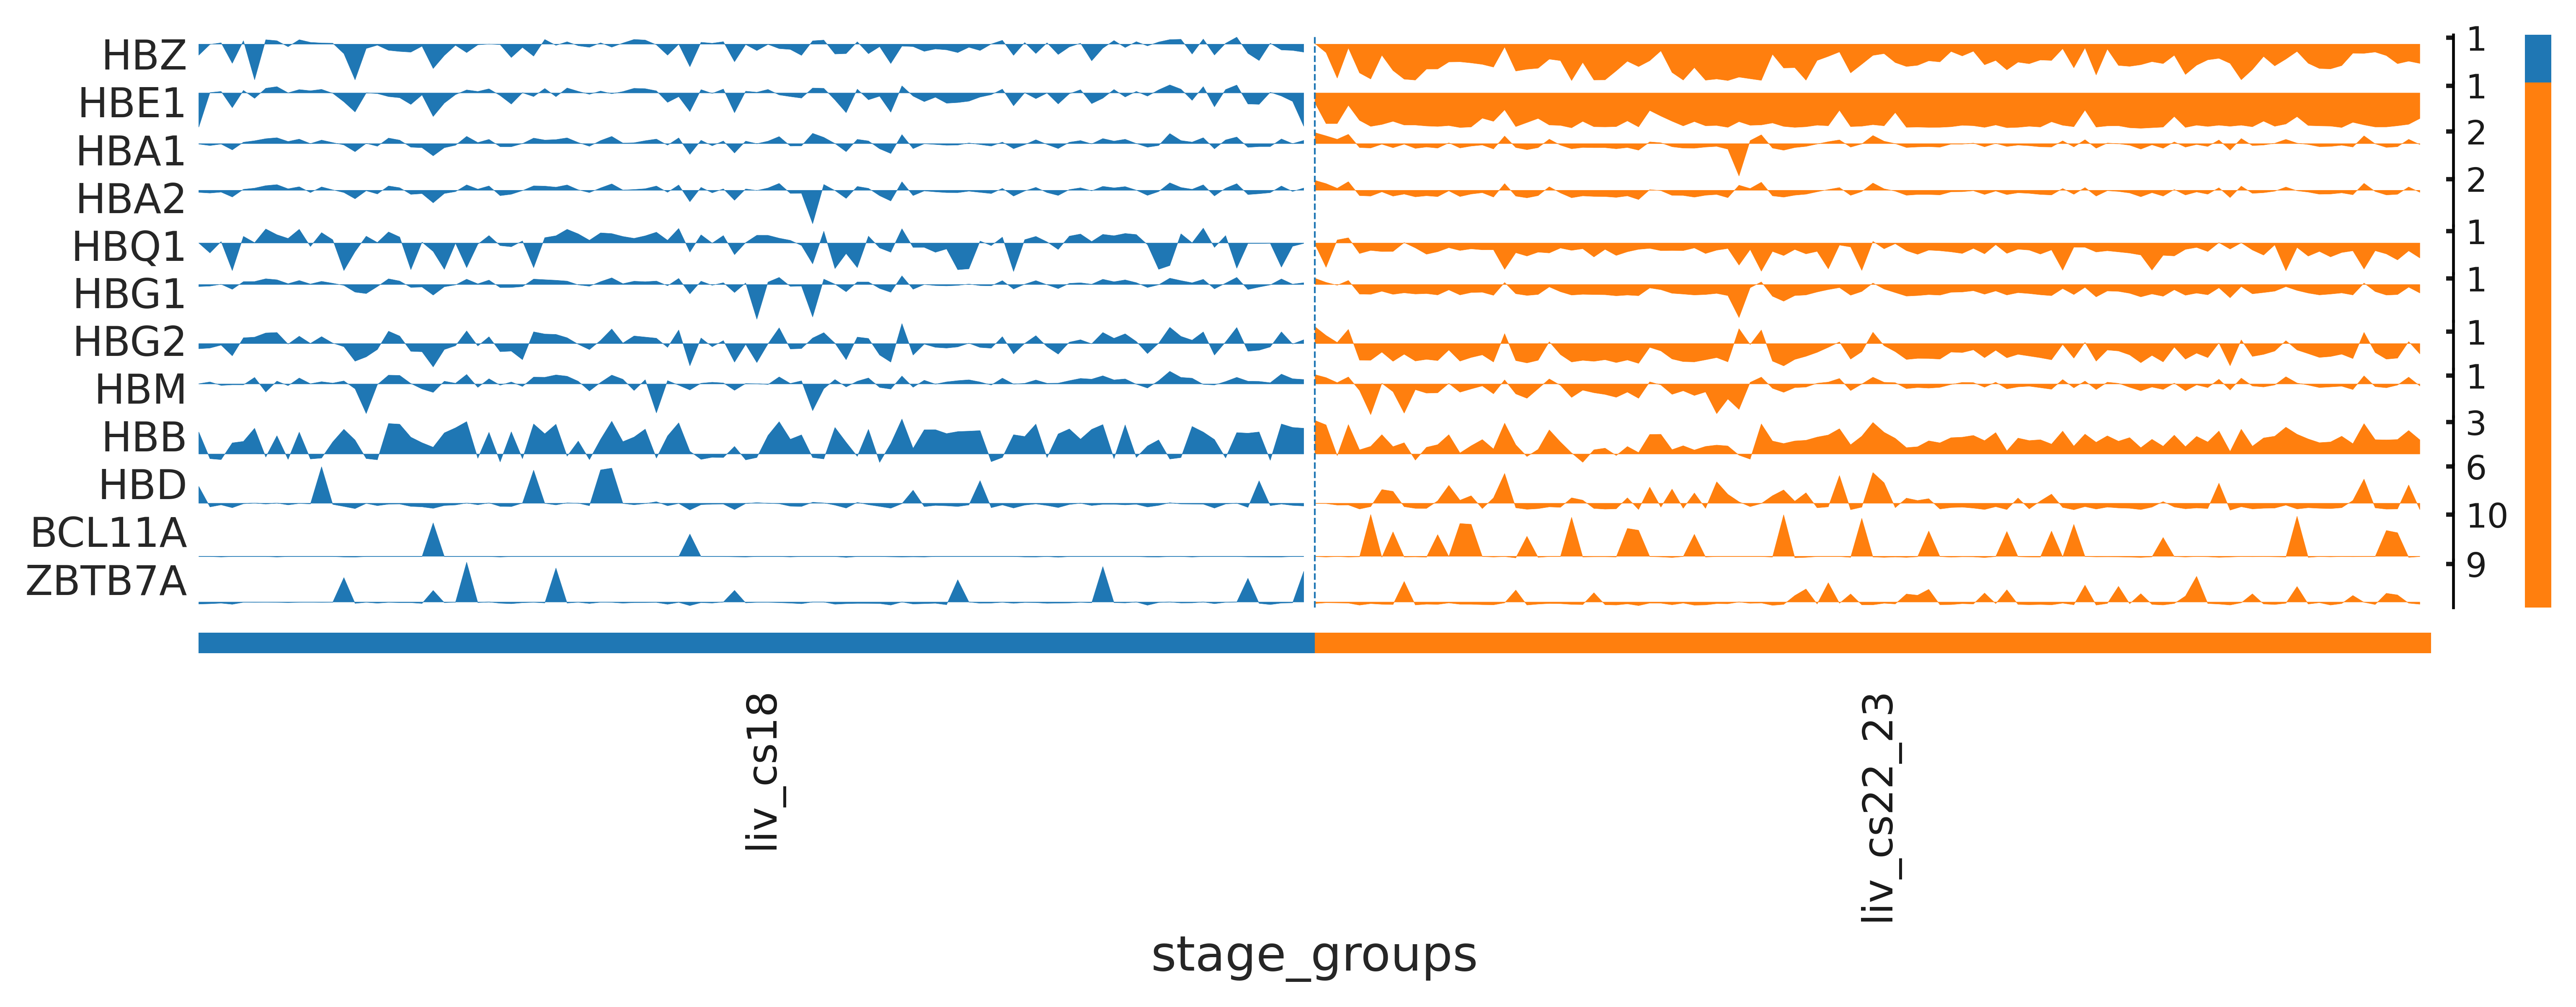

In [140]:
# YS plot
adata_subsamp_tmp = adata_subsamp[~adata_subsamp.obs['stage_groups'].str.contains('liv')]
adata_subsamp_tmp.obs['stage_groups'] = adata_subsamp_tmp.obs['stage_groups'].astype('category')
ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23']
adata_subsamp_tmp.obs['stage_groups'] = pd.Categorical(adata_subsamp_tmp.obs['stage_groups'], categories=ordering) 
sc.pl.tracksplot(adata_subsamp_tmp,markers, groupby='stage_groups',scale_var = 'var')
# fliv plot

adata_subsamp_tmp = adata_subsamp[adata_subsamp.obs['stage_groups'].str.contains('liv')]
adata_subsamp_tmp.obs['stage_groups'] = adata_subsamp_tmp.obs['stage_groups'].astype('category')
ordering =  ['liv_cs18','liv_cs22_23']
adata_subsamp_tmp.obs['stage_groups'] = pd.Categorical(adata_subsamp_tmp.obs['stage_groups'], categories=ordering) 
sc.pl.tracksplot(adata_subsamp_tmp,markers, groupby='stage_groups')

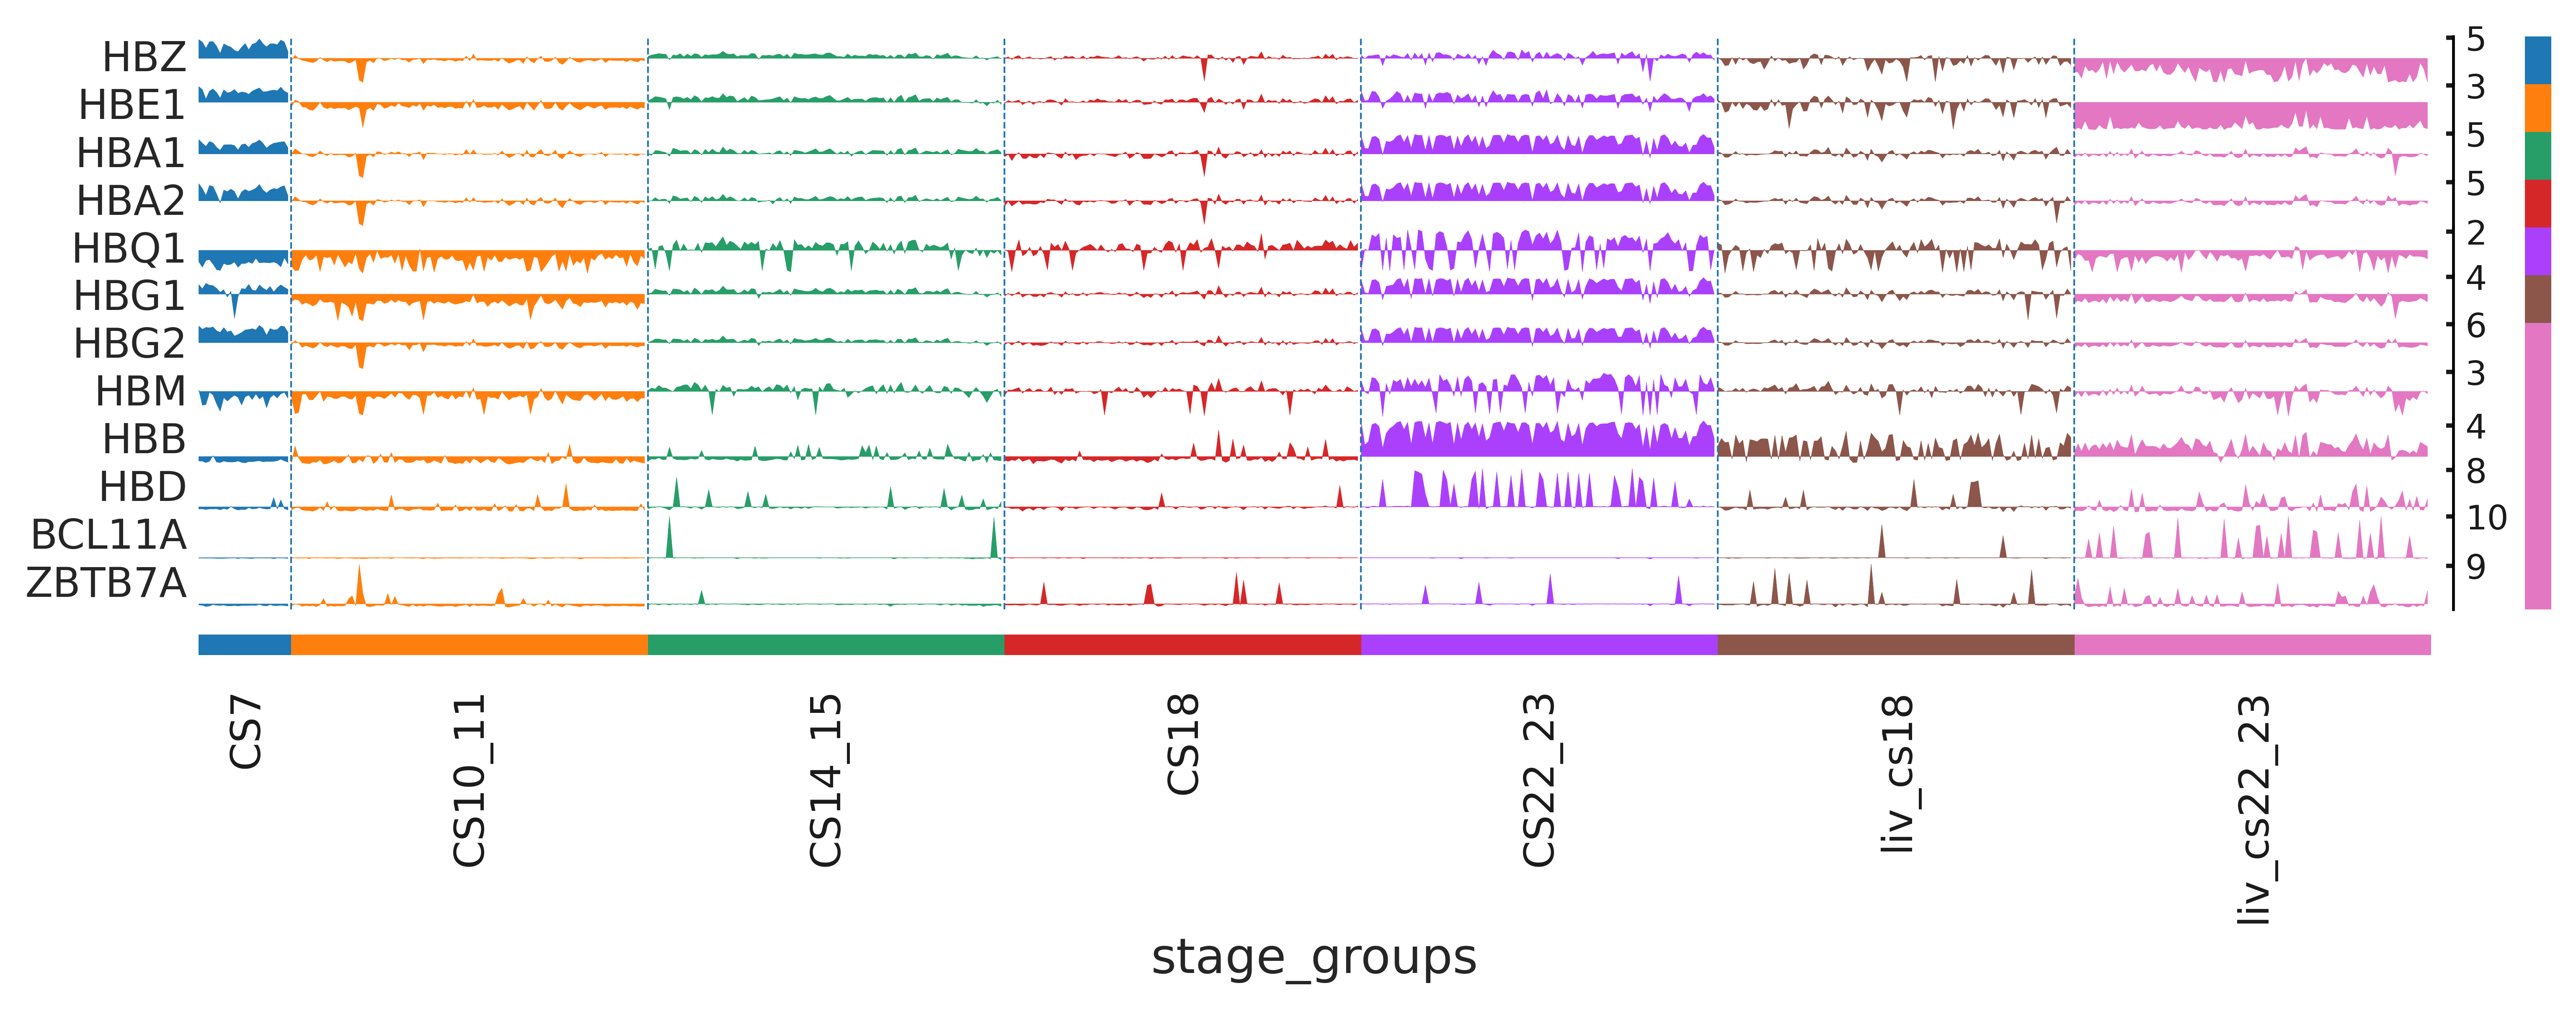

In [141]:
adata_subsamp.obs['stage_groups'] = adata_subsamp.obs['stage_groups'].astype('category')
ordering =  ['CS7', 'CS10_11', 'CS14_15', 'CS18','CS22_23','liv_cs18','liv_cs22_23']
adata_subsamp.obs['stage_groups'] = pd.Categorical(adata_subsamp.obs['stage_groups'], categories=ordering) 
sc.pl.tracksplot(adata_subsamp,markers, groupby='stage_groups')

In [28]:
# sc.pl.heatmap(adata_subsamp, markers, groupby='stage_groups', figsize=(5, 8),
#               var_group_positions=[(0,1), (11, 12)], use_raw=False, vmin=0, vmax=1,
#               var_group_rotation=0,save = 'heatmap_primitive_repressors')

In [ ]:
with rc_context({'figure.figsize': (9, 1.5)}):
    sc.pl.rank_genes_groups_violin(pbmc, n_genes=20, jitter=False)

In [ ]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig2_Haem/Erytrhroid_HB_percentage/YS_fliv_ery_HB.h5ad')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata_concat = adata[adata.obs['stage']==0]
for i in adata.obs['stage'].unique():
    tmp = adata[adata.obs['stage'].isin([i])]
    sc.pp.scale(tmp, max_value=None,zero_center=False)
    adata_concat = adata_concat.concatenate(tmp, join='inner')
adata = adata_concat[:]

stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15','F61', 'F35', 'F32']
groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15','liv_cs18','liv_cs22_23','liv_cs22_23']
dic = dict(zip(stages,groups))
adata.obs['stage_groups'] = adata.obs['stage'].map(dic)
adata.obs['stage_groups'].unique()
adata_subsamp = adata[adata.obs.index.isin(adata.obs.groupby(['stage_groups']).head(1000).index)]
# markers = ['BCL11A','ZBTB7A']